In [148]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
from ipyparallel import Client
import traceback
from itertools import product, combinations
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from math import comb
from datetime import datetime

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

prospective_preexpert_animals = ['DS_16','BS_85','BS_95','BS_113']#BS_50

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#,'AE_267']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching files for DS_16
Fetching files for DS_17
Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

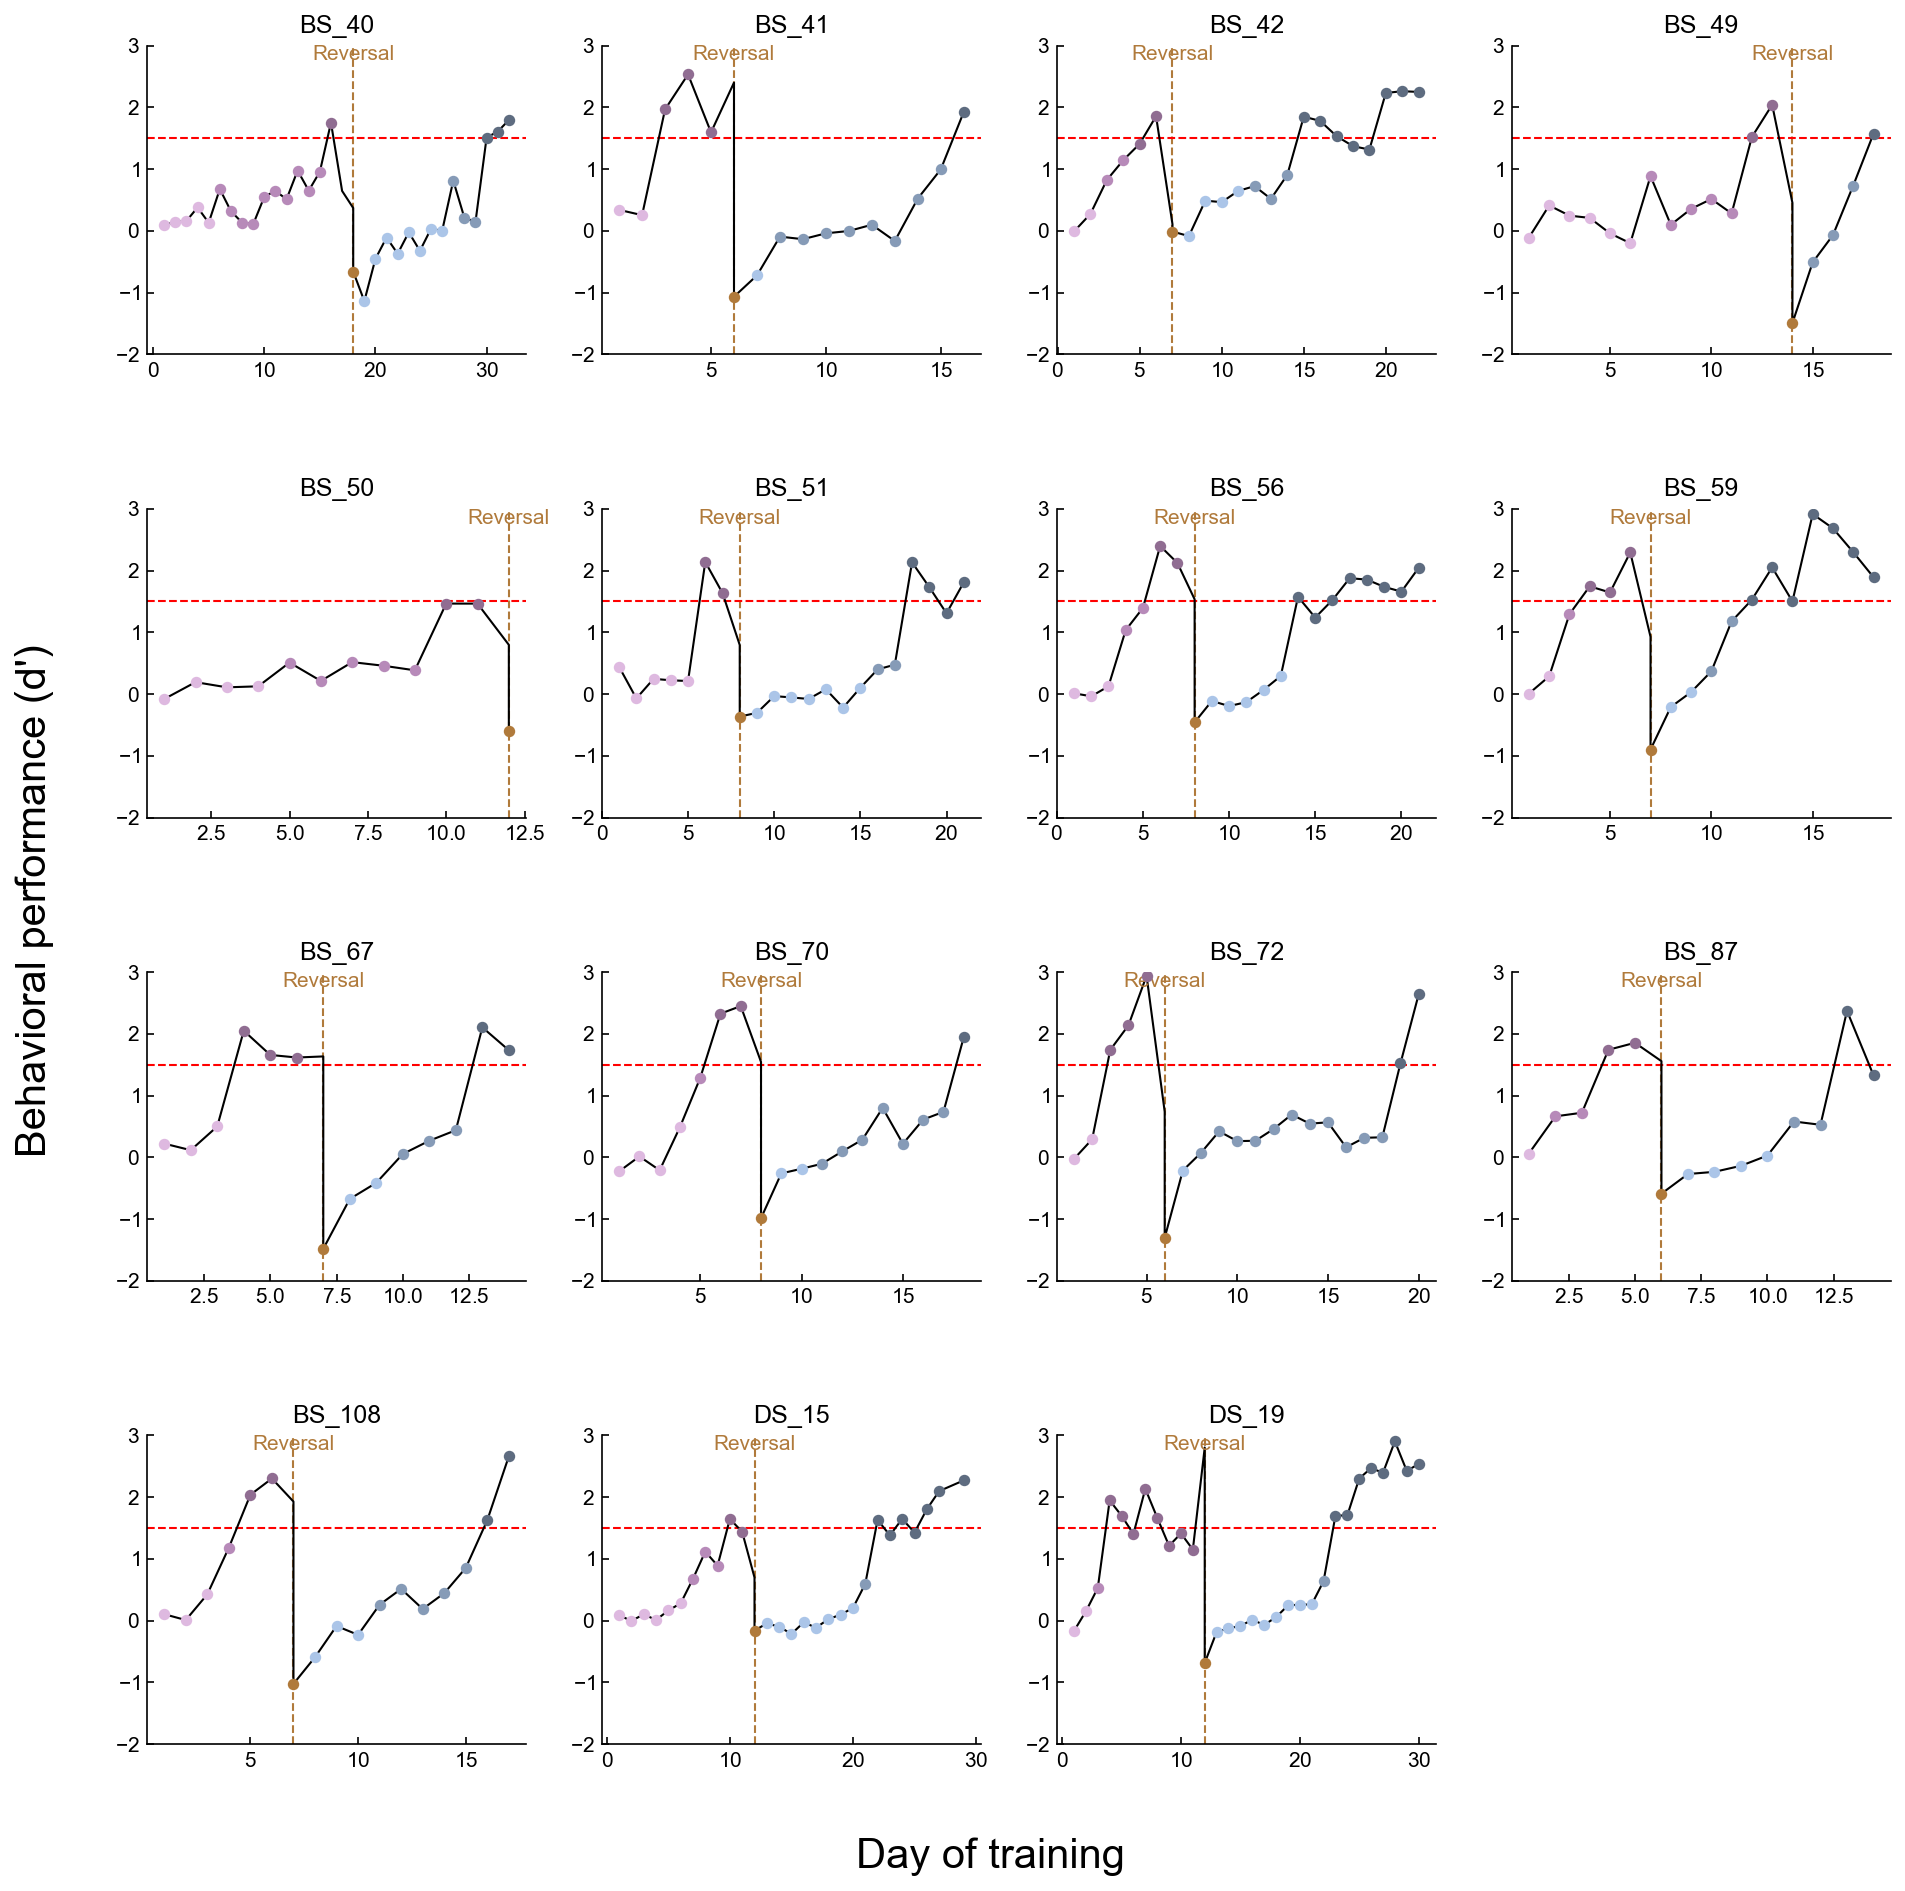

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


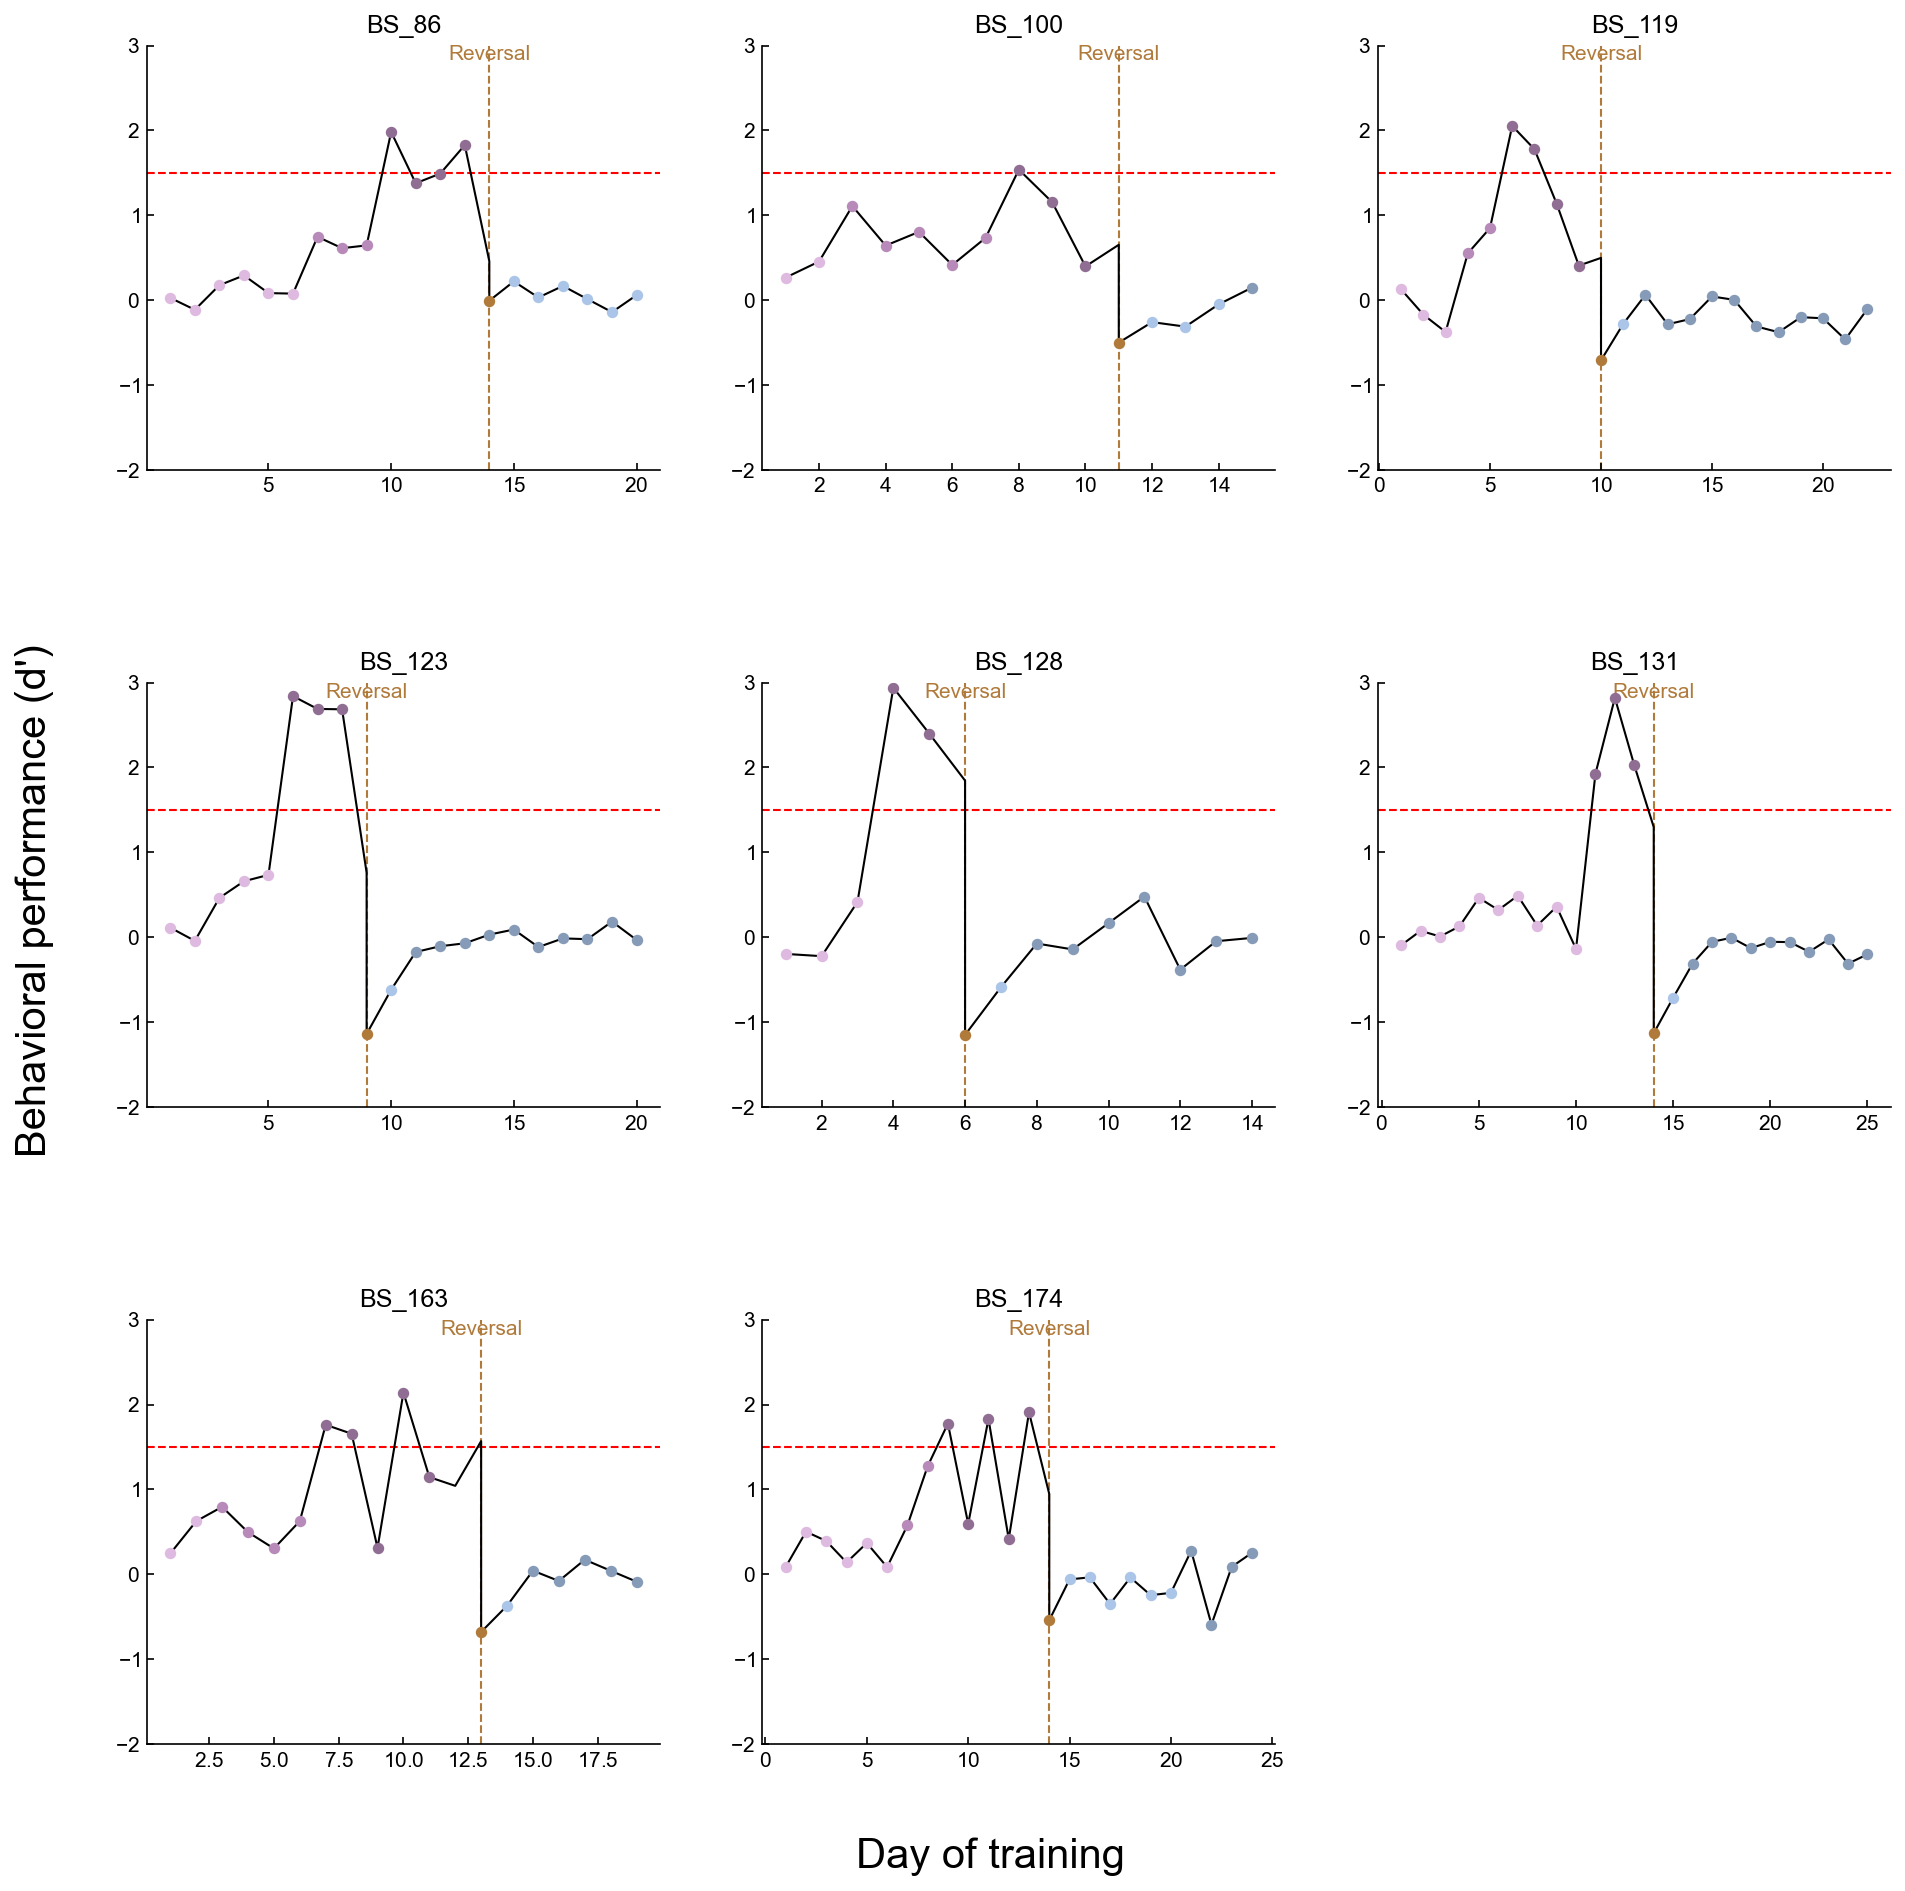

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True,noTrim=False)
learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
for d in learning_phases2:
    learning_phases[d] = learning_phases2[d]

In [5]:
EnumSessionOps = []
# EnumClust = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in did_not_learn:
        continue
    
    EnumSessionOps.append(session)
    
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)

100%|██████████| 167/167 [00:03<00:00, 49.38it/s]


In [6]:
EILphasesOps = np.full_like(EnumSessionOps,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionOps)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        rev_day = animalBehaviors[sessionfile.meta.animal].reversal
        day_relative_to_rev = day - rev_day
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphasesOps[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesOps[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesOps[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesOps[idx] = 'pre expert'

        elif day_relative_to_rev in [1,2,3,4]:
            EILphasesOps[idx] = 'post early'
        elif day_relative_to_rev in [5,6,7]:
            EILphasesOps[idx] = 'post late'
        elif day_relative_to_rev >= 8:
            EILphasesOps[idx] = 'post expert'
    except Exception as e:
#         print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        print(e)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 59/59 [00:00<00:00, 82.15it/s] 

errors for: []


In [7]:
EnumSession = []
# EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    EnumSession.append(session)
    
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)

100%|██████████| 740/740 [00:11<00:00, 62.51it/s] 


In [8]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 144/144 [00:01<00:00, 108.41it/s]

errors for: []


In [23]:
# dim25msfilename = 'D:\\dimenstionality_25ms.csv'
# dim50msfilename = 'D:\\dimenstionality_50ms.csv'
# dim100msfilename = 'D:\\dimenstionality_100ms.csv'
# dimsize5filename = 'D:\\dimenstionality_size5.csv'
# dimsize10filename = 'D:\\dimenstionality_size10.csv'
# dimsize15filename = 'D:\\dimenstionality_size15.csv'
dimhighitersfilename = 'D:\\dimenstionality_highIters.csv'
dimhighiterss4filename = 'D:\\dimenstionality_highIters_s4.csv'
dimhighiterss6filename = 'D:\\dimenstionality_highIters_s6.csv'
dimhighiterssmaxfilename = 'D:\\dimenstionality_highIters_smax.csv'
dim200highiterss6filename = 'D:\\dimenstionality_200ms_highIters_s6.csv'
dimoptohighitersfilename = 'D:\\dimenstionality_opsin_highIters.csv'
dimoptohighiterss6filename = 'D:\\dimenstionality_opsin_highIters_s6.csv'

In [25]:
# dim_25ms_df = pd.read_csv(dim25msfilename)
# dim_50ms_df = pd.read_csv(dim50msfilename)
# dim_100ms_df = pd.read_csv(dim100msfilename)
# dim_size5_df = pd.read_csv(dimsize5filename)
# dim_size10_df = pd.read_csv(dimsize10filename)
# dim_size15_df = pd.read_csv(dimsize15filename)
dim_highIters_df = pd.read_csv(dimhighitersfilename)
dim_highIters_s4_df = pd.read_csv(dimhighiterss4filename)
dim_highIters_s6_df = pd.read_csv(dimhighiterss6filename)
dim_highIters_smax_df = pd.read_csv(dimhighiterssmaxfilename)
dim_200ms_highIters_s6_df = pd.read_csv(dim200highiterss6filename)
dim_opto_highIters_df = pd.read_csv(dimoptohighitersfilename)
dim_opto_highIters_s6_df = pd.read_csv(dimoptohighiterss6filename)
# dim_df = pd.concat([dim_25ms_df,dim_50ms_df,dim_100ms_df,dim_size5_df,dim_size10_df,dim_size15_df])
# dim_df = pd.concat([dim_highIters_s6_df,dim_opto_highIters_s6_df])
dim_df = dim_highIters_smax_df#dim_200ms_highIters_s6_df

# passive_df = pd.read_csv(passivedecodingfilename)
# choice_df = pd.read_csv(choicedecodingfilename)
# dec_df = pd.concat([stim_25s_df,choice_df,passive_df])

def getDataPoints(df,session,binlength,size,column):
    df = df[df['session']==session]
    df = df[df['bin_length']==binlength]
    df = df[df['size']==size]
    val = list(df[column])
    
    return val
#     if len(val) == 1:
#         return val[0]
#     elif len(val) <= 0:
#         return np.nan
#     else:
#         return val

In [26]:
dim_df

,Unnamed: 0,bin_length,size,session,clust,sampling_coefficient,max_iters,d_var,d_covar,d_GT,FRmods,NCR_ratio,indiv
0,0,50.0,23,AE_238_10_AC.pickle,[ 7 17 18 26 35 38 48 49 52 55 58 ...,10,100,NaN,NaN,NaN,"[4.05466970387243, 1.67046317388003, 2.4601366...",0.652174,[nan nan nan nan nan nan nan nan nan nan nan n...
1,1,50.0,36,AE_238_11_AC.pickle,[ 5 15 21 41 48 51 55 68 76 84 86 ...,10,100,NaN,NaN,NaN,"[31.98924731182799, 4.289855072463769, 11.0984...",0.444444,[nan nan nan nan nan nan nan nan nan nan nan n...
2,2,50.0,54,AE_238_12_AC.pickle,[ 5 28 36 44 60 61 62 66 70 71 72 ...,10,100,NaN,NaN,NaN,"[2.202380952380951, 0.572597137014315, 0.61111...",0.796296,[nan nan nan nan nan nan nan nan nan nan nan n...
3,3,50.0,19,AE_238_13_AC.pickle,[ 1 4 9 22 23 24 31 32 51 53 75 ...,10,100,7.124886,18.584502,6.969076,"[2.1732745961820865, 0.2949852507374631, 1.671...",0.631579,[0.26318191 0.08925348 0.7378633 0.11476858 0...
4,4,50.0,15,AE_238_14_AC.pickle,[ 43 65 73 76 79 92 93 100 105 115 201 2...,10,100,NaN,NaN,NaN,"[1.098039215686274, 2.08627450980392, 0.679012...",0.800000,[nan nan nan nan nan nan nan nan nan nan nan n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409,50.0,23,DS_28_4_AC.pickle,[ 2 6 25 27 35 42 45 47 95 110 116 1...,10,100,NaN,NaN,NaN,"[1.5672514619883016, 10.293333333333337, 38.58...",0.608696,[nan nan nan nan nan nan nan nan nan nan nan n...
410,410,50.0,10,DS_28_5_AC.pickle,[ 0 2 8 10 11 33 38 40 42 46],10,100,3.933147,9.913848,3.899262,"[6.198439241917503, 0.2452619843924194, 2.6978...",0.800000,[0.20000059 0.11630279 0.21041514 0.11318847 0...
411,411,50.0,21,DS_28_6_AC.pickle,[ 0 2 6 7 26 27 28 30 34 36 49 50 51 52 57 ...,10,100,13.682059,20.672128,13.468442,"[1.5527065527065513, 0.7549857549857549, 2.108...",0.904762,[0.14870857 0.21702709 0.84023218 0.29095908 0...
412,412,50.0,32,DS_28_8_AC.pickle,[ 0 1 5 6 7 19 20 21 28 33 36 ...,10,100,NaN,NaN,NaN,"[2.1500000000000004, 0.5128205128205128, 0.716...",0.593750,[nan nan nan nan nan nan nan nan nan nan nan n...


In [12]:
getDataPoints(dim_df,'BS_128_7_opto_AC.pickle',50,6,'d_GT')

[]

# Ephys Controls

In [14]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def plotFigure(bin_length,size_of_ensembles,metric,profiles='all'):
    fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
    switch_offset = 0.25

    ################################################################################################################

    size = 10
    summary_size=100
    summary_width=1#0.75

    mn = 3.5
    spread = 2.5

    ###

    FRmod_baseline_median = 3.5
    phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    data = [0,0,0,0,0,0]
    data_NCR_ratio = [0,0,0,0,0,0]
    for idx,phase in enumerate(phases):
        phase_idx = np.char.equal(EILphases,phase)
        sessions_in_phase = np.array(EnumSession)[phase_idx]

        temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,metric) for session in sessions_in_phase]
        temp = [t for t in temp if len(t)>0]
        temp = np.concatenate(temp)
        data[idx] = temp

        temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,'NCR_ratio') for session in sessions_in_phase]
        temp = [t for t in temp if len(t)>0]
        temp = np.concatenate(temp)
        data_NCR_ratio[idx] = temp
        
    ##############
    for idx,phase in enumerate(phases):
        if profiles == 'CR':
            mask = np.less_equal(data_NCR_ratio[idx],0.3)
        elif profiles == 'Mixed':
            mask = np.logical_and(np.greater_equal(data_NCR_ratio[idx],0.5),np.less_equal(data_NCR_ratio[idx],0.7))
        elif profiles == 'NCR':
            mask = np.greater_equal(data_NCR_ratio[idx],0.8)
        else:
            mask = np.ones_like(data_NCR_ratio[idx],dtype='bool')  
        data[idx] = data[idx][mask]
        data_NCR_ratio[idx] = data_NCR_ratio[idx][mask]
    ##############

    data = np.array(data)
    data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))
    labels = ['Early','Late','Expert','Early','Late','Expert']
    numCon = len(data)

    ###
    X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
    _,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5,minjitter=0.075)
    X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5,minjitter=0.075)
    colors = NCR_CR_cmap( (1-data_NCR_ratio) )

    ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

    #Plot summary
    for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
        column = ilep.rmnan(column)
        if len(column) == 0:
            continue
            
        percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100

        eye_color = PHASE_COLORS[idx]
        border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    #     r,g,b = mpl.colors.to_rgb(eye_color)
    #     h,l,s = colorsys.rgb_to_hls(r,g,b)

        Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    #     median = np.mean(column)
    #     Q1 = median - sem(column)
    #     Q1 = median + sem(column)

        ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


    ################################################################################################################
    labels = ['Early','Late','Expert','Early','Late','Expert']

    if metric == 'd_covar':
        ax.set_ylim([0.6*size_of_ensembles,size_of_ensembles])
        ax.set_yticks(np.array([3,4,5])*size_of_ensembles/5)
    else:
        ax.set_ylim([0,size_of_ensembles])
        ax.set_yticks(np.array([0,1,2,3,4,5])*size_of_ensembles/5)
    # ax.set_yticks([0,1,2,3,4,5])
    ylab = ax.set_ylabel('Dimensions')

    ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
    ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
    ax.set_xticklabels(labels)
    # xlab = ax.set_xlabel('Example X label')

    xtick_pos_pre = ax.get_xticks()[1]
    xtick_pos_post = ax.get_xticks()[4]
    Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
    t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
    t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
    ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    ax.tick_params(direction='in', length=6, width=1)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass

    Y = np.mean(ax.get_ylim())
    t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
    ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.3],lw=1,color=SWITCH_COLOR)
    ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.3],lw=1,color=SWITCH_COLOR)

    # ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

    ttl = ax.set_title(' ')
    artists = [ylab,t1,t2,ttl]
    fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC dimensionality '+profiles+' ensembles 200ms '+str(bin_length)+'ms size '+str(size_of_ensembles)+' '+metric+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    
    data_dec = SimpleNamespace()
    data_dec.preearly = np.abs(data[0])
    data_dec.prelate = np.abs(data[1])
    data_dec.preexpert = np.abs(data[2])
    data_dec.postearly = np.abs(data[3])
    data_dec.postlate = np.abs(data[4])
    data_dec.postexpert = np.abs(data[5])
    print(f"bin length {bin_length}, size {size_of_ensembles}, metric {metric}")
    ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)

<ipython-input-14-2f656408d2a1>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-14-2f656408d2a1>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))


bin length 50, size 6, metric d_var
            Source            SS       DF         MS          F         p-unc  \
0            phase     81.716696      3.0  27.238899  30.699590  8.725833e-20   
1          context      5.604832      1.0   5.604832   6.316924  1.196796e-02   
2  phase * context    204.456168      3.0  68.152056  76.810747  2.342534e-49   
3         Residual  15596.474209  17578.0   0.887272        NaN           NaN   

        np2  
0  0.005212  
1  0.000359  
2  0.012940  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.175904e-22  4.703617e-22 -0.337566
8     post-late  baseline  experimental  2.104461e-09  2.805948e-09  0.156910
9    pre-expert  baseline  experimental  8.277690e-01  8.277690e-01  0.004450
10     pre-late  baseline  experimental  3.194949e-16  6.389898e-16  0.317128
key preearly has 1430 non-nan elements
key prelate has 1587 non-nan elements
key preexpert has 30

<ipython-input-14-2f656408d2a1>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-14-2f656408d2a1>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))


bin length 50, size 6, metric d_covar
            Source          SS       DF        MS           F          p-unc  \
0            phase    6.014576      3.0  2.004859   99.246033   1.059540e-63   
1          context    1.377896      1.0  1.377896   68.209654   1.573362e-16   
2  phase * context   11.424602      3.0  3.808201  188.516429  2.505090e-120   
3         Residual  355.091326  17578.0  0.020201         NaN            NaN   

        np2  
0  0.016656  
1  0.003865  
2  0.031171  
3       NaN  

          phase         A             B          p-unc         p-corr  \
7   post-expert  baseline  experimental   6.158665e-71   1.231733e-70   
8     post-late  baseline  experimental  1.578376e-118  6.313502e-118   
9    pre-expert  baseline  experimental   2.389624e-05   2.389624e-05   
10     pre-late  baseline  experimental   3.169442e-19   4.225922e-19   

      hedges  
7  -0.406179  
8   0.513400  
9  -0.103587  
10  0.171482  
key preearly has 1430 non-nan elements
key prelat

<ipython-input-14-2f656408d2a1>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-14-2f656408d2a1>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))


bin length 50, size 6, metric d_GT
            Source            SS       DF         MS           F  \
0            phase    105.955950      3.0  35.318650   41.439302   
1          context      8.609089      1.0   8.609089   10.101027   
2  phase * context    259.323233      3.0  86.441078  101.421144   
3         Residual  14981.701095  17578.0   0.852298         NaN   

          p-unc       np2  
0  1.124267e-26  0.007023  
1  1.484433e-03  0.000574  
2  4.331236e-65  0.017015  
3           NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  3.851760e-30  1.540704e-29 -0.382061
8     post-late  baseline  experimental  1.098102e-14  1.464136e-14  0.199621
9    pre-expert  baseline  experimental  8.133253e-01  8.133253e-01 -0.021818
10     pre-late  baseline  experimental  1.594604e-18  3.189208e-18  0.343141
key preearly has 1430 non-nan elements
key prelate has 1587 non-nan elements
key preexpert ha

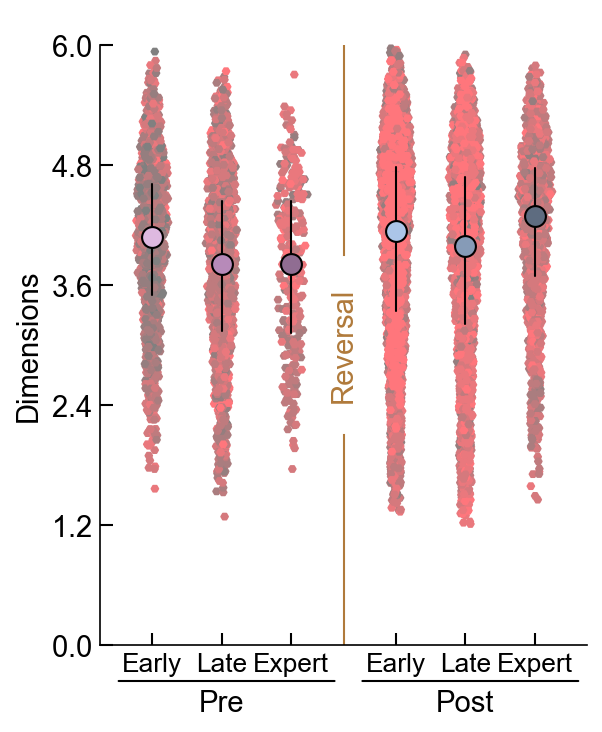

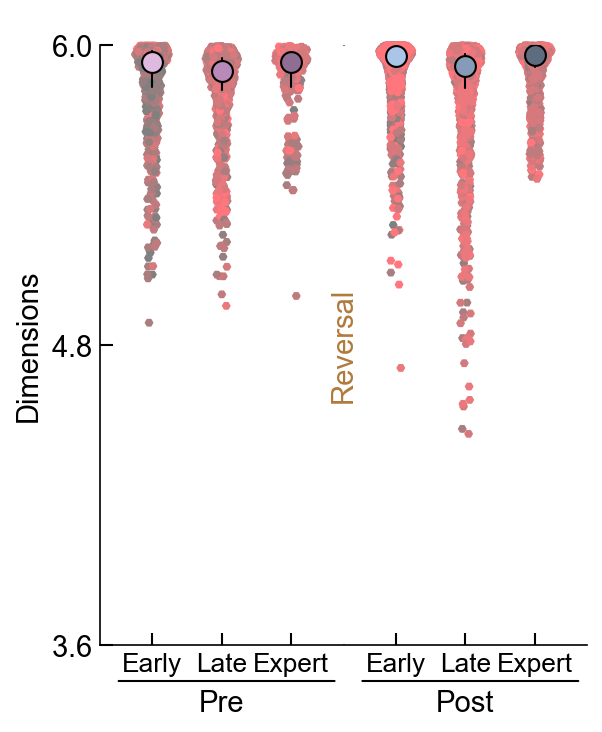

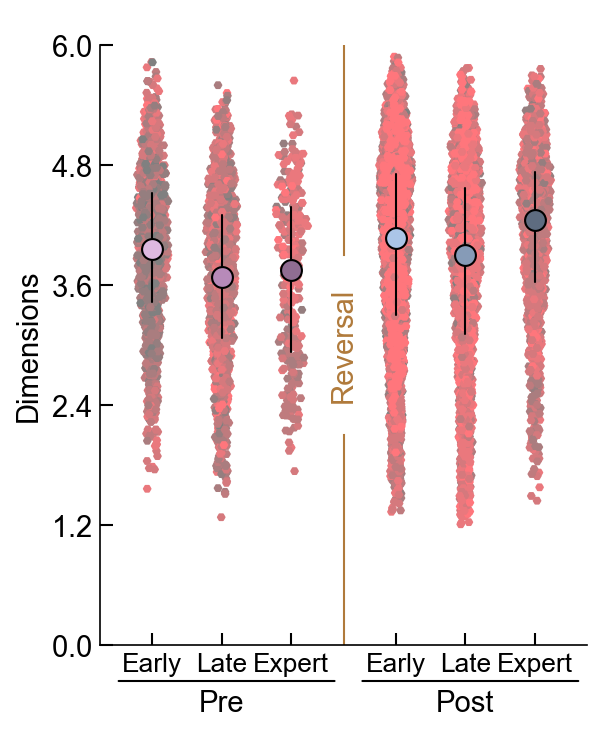

In [15]:
bin_lengths = [25,50,100]
sizes = [5,10,15]
profiles = ['all','CR','Mixed','NCR']
metrics = ['d_var','d_covar','d_GT']

profiles=['all']
# for b,m in product(bin_lengths,metrics):
#     try:
#         plotFigure(b,10,m)
#     except:
#         pass
    
for p,m in product(profiles,metrics):
    try:
        plotFigure(50,6,m,profiles=p)
    except:
        pass

# Opto

In [107]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def plotFigureOpto(bin_length,size_of_ensembles,metric,profiles='all'):
    fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
    switch_offset = 0.25

    ################################################################################################################

    size = 10
    summary_size=100
    summary_width=1#0.75

    mn = 3.5
    spread = 2.5

    ###

    FRmod_baseline_median = 3.5
    phases = ['post early','post late','post expert']
    data = [0,0,0]
    data_NCR_ratio = [0,0,0]
    for idx,phase in enumerate(phases):
        phase_idx = np.char.equal(EILphasesOps,phase)
        sessions_in_phase = np.array(EnumSessionOps)[phase_idx]

        print(sessions_in_phase)
        
        temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,metric) for session in sessions_in_phase]
        temp = [t for t in temp if len(t)>0]
        temp = np.concatenate(temp)
        data[idx] = temp

        temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,'NCR_ratio') for session in sessions_in_phase]
        temp = [t for t in temp if len(t)>0]
        temp = np.concatenate(temp)
        data_NCR_ratio[idx] = temp
        
    ##############
    for idx,phase in enumerate(phases):
        if profiles == 'CR':
            mask = np.less_equal(data_NCR_ratio[idx],0.3)
        elif profiles == 'Mixed':
            mask = np.logical_and(np.greater_equal(data_NCR_ratio[idx],0.5),np.less_equal(data_NCR_ratio[idx],0.7))
        elif profiles == 'NCR':
            mask = np.greater_equal(data_NCR_ratio[idx],0.8)
        else:
            mask = np.ones_like(data_NCR_ratio[idx],dtype='bool')  
        data[idx] = data[idx][mask]
        data_NCR_ratio[idx] = data_NCR_ratio[idx][mask]
    ##############

    data = np.array(data)
    data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))
    labels = ['Early','Late','Expert','Early','Late','Expert']
    numCon = len(data)

    ###
    X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
    _,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5,minjitter=0.075)
    X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5,minjitter=0.075)
    colors = NCR_CR_cmap( (1-data_NCR_ratio) )

    ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

    #Plot summary
    for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
        column = ilep.rmnan(column)
        if len(column) == 0:
            continue
            
        percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100

        eye_color = PHASE_COLORS[idx]
        border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    #     r,g,b = mpl.colors.to_rgb(eye_color)
    #     h,l,s = colorsys.rgb_to_hls(r,g,b)

        Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    #     median = np.mean(column)
    #     Q1 = median - sem(column)
    #     Q1 = median + sem(column)

        ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


    ################################################################################################################
    labels = ['Early','Late','Expert','Early','Late','Expert']

    if metric == 'd_covar':
        ax.set_ylim([0.6*size_of_ensembles,size_of_ensembles])
        ax.set_yticks(np.array([3,4,5])*size_of_ensembles/5)
    else:
        ax.set_ylim([0,size_of_ensembles])
        ax.set_yticks(np.array([0,1,2])*size_of_ensembles/5)
    ax.set_yticks([0,1,2,3,4,5,6])
    ylab = ax.set_ylabel('Dimensions')

    ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
    ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
    ax.set_xticklabels(labels)
    # xlab = ax.set_xlabel('Example X label')

    xtick_pos_pre = ax.get_xticks()[1]
    xtick_pos_post = ax.get_xticks()[4]
    Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
    t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
    t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
    ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    ax.tick_params(direction='in', length=6, width=1)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass

    Y = np.mean(ax.get_ylim())
    t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
    ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.3],lw=1,color=SWITCH_COLOR)
    ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.3],lw=1,color=SWITCH_COLOR)

    # ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

    ttl = ax.set_title(' ')
    artists = [ylab,t1,t2,ttl]
    fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC opto dimensionality '+profiles+' ensembles '+str(bin_length)+'ms size '+str(size_of_ensembles)+' '+metric+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    
    data_dec = SimpleNamespace()
    data_dec.preearly = np.abs(data[0])
    data_dec.prelate = np.abs(data[1])
    data_dec.preexpert = np.abs(data[2])
    data_dec.postearly = [np.nan]#np.abs(data[3])
    data_dec.postlate = [np.nan]#np.abs(data[4])
    data_dec.postexpert = [np.nan]#np.abs(data[5])
    print(f"bin length {bin_length}, size {size_of_ensembles}, metric {metric}")
    ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)

['BS_119_2_opto_AC.pickle' 'BS_119_3_opto_AC.pickle'
 'BS_119_4_opto_AC.pickle' 'BS_119_5_opto_AC.pickle'
 'BS_123_2_opto_AC.pickle' 'BS_123_3_opto_AC.pickle'
 'BS_123_4_opto_AC.pickle' 'BS_123_5_opto_AC.pickle'
 'BS_128_4_opto_AC.pickle' 'BS_128_5_opto_AC.pickle'
 'BS_128_6_opto_AC.pickle' 'BS_128_7_opto_AC.pickle'
 'BS_131_2_opto_AC.pickle' 'BS_131_3_opto_AC.pickle'
 'BS_131_4_opto_AC.pickle' 'BS_131_5_opto_AC.pickle'
 'BS_163_10_opto_AC.pickle' 'BS_174_2_opto_AC.pickle'
 'BS_174_3_opto_AC.pickle' 'BS_86_2_opto_AC.pickle'
 'BS_86_3_opto_AC.pickle' 'BS_86_4_opto_AC.pickle'
 'BS_86_5_opto_AC.pickle']
['BS_119_6_opto_AC.pickle' 'BS_123_6_opto_AC.pickle'
 'BS_123_7_opto_AC.pickle' 'BS_128_10_opto_AC.pickle'
 'BS_128_8_opto_AC.pickle' 'BS_128_9_opto_AC.pickle'
 'BS_131_6_opto_AC.pickle' 'BS_131_7_opto_AC.pickle'
 'BS_131_8_opto_AC.pickle' 'BS_86_6_opto_AC.pickle'
 'BS_86_7_opto_AC.pickle' 'BS_86_8_opto_AC.pickle']
['BS_123_8_opto_AC.pickle' 'BS_128_11_opto_AC.pickle'
 'BS_174_5_opto_AC.pi

<ipython-input-107-530bf8e6b286>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-107-530bf8e6b286>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))


bin length 50, size 6, metric d_var
            Source           SS      DF         MS           F         p-unc  \
0            phase    20.633373     1.0  20.633373   22.590153  2.114278e-06   
1          context    20.633373     1.0  20.633373   22.590153  2.114278e-06   
2  phase * context    93.532746     1.0  93.532746  102.402989  1.233202e-23   
3         Residual  2375.698955  2601.0   0.913379         NaN           NaN   

        np2  
0  0.008610  
1  0.008610  
2  0.037879  
3       NaN  

        phase         A             B         p-unc        p-corr    hedges
2  pre-expert  baseline  experimental  1.075135e-22  2.150271e-22  0.971395
3    pre-late  baseline  experimental  1.036112e-02  1.036112e-02 -0.180684
key preearly has 1876 non-nan elements
key prelate has 223 non-nan elements
key preexpert has 283 non-nan elements
key postearly has 0 non-nan elements
key postlate has 0 non-nan elements
key postexpert has 0 non-nan elements
['BS_119_2_opto_AC.pickle' 'BS_119_3_o

<ipython-input-107-530bf8e6b286>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-107-530bf8e6b286>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))


bin length 50, size 6, metric d_covar
            Source         SS      DF        MS          F         p-unc  \
0            phase   0.566399     1.0  0.566399  22.085126  2.744082e-06   
1          context   0.566399     1.0  0.566399  22.085126  2.744082e-06   
2  phase * context   0.798254     1.0  0.798254  31.125635  2.668260e-08   
3         Residual  66.705716  2601.0  0.025646        NaN           NaN   

        np2  
0  0.008420  
1  0.008420  
2  0.011825  
3       NaN  

        phase         A             B         p-unc        p-corr    hedges
2  pre-expert  baseline  experimental  8.710789e-01  8.710789e-01  0.198542
3    pre-late  baseline  experimental  2.684957e-21  5.369915e-21 -0.474709
key preearly has 1876 non-nan elements
key prelate has 223 non-nan elements
key preexpert has 283 non-nan elements
key postearly has 0 non-nan elements
key postlate has 0 non-nan elements
key postexpert has 0 non-nan elements
['BS_119_2_opto_AC.pickle' 'BS_119_3_opto_AC.pickle'
 'B

<ipython-input-107-530bf8e6b286>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-107-530bf8e6b286>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.concatenate(np.array(data_NCR_ratio))


bin length 50, size 6, metric d_GT
            Source           SS      DF          MS           F         p-unc  \
0            phase    16.085199     1.0   16.085199   18.398694  1.857194e-05   
1          context    16.085199     1.0   16.085199   18.398694  1.857194e-05   
2  phase * context   101.312969     1.0  101.312969  115.884567  1.803571e-26   
3         Residual  2273.944149  2601.0    0.874258         NaN           NaN   

        np2  
0  0.007024  
1  0.007024  
2  0.042653  
3       NaN  

        phase         A             B         p-unc        p-corr    hedges
2  pre-expert  baseline  experimental  2.275886e-23  4.551772e-23  0.988549
3    pre-late  baseline  experimental  8.717835e-04  8.717835e-04 -0.234945
key preearly has 1876 non-nan elements
key prelate has 223 non-nan elements
key preexpert has 283 non-nan elements
key postearly has 0 non-nan elements
key postlate has 0 non-nan elements
key postexpert has 0 non-nan elements


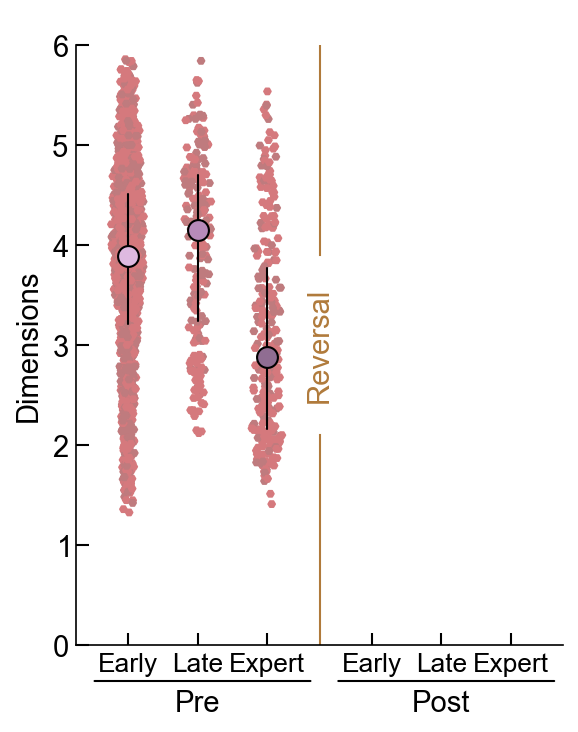

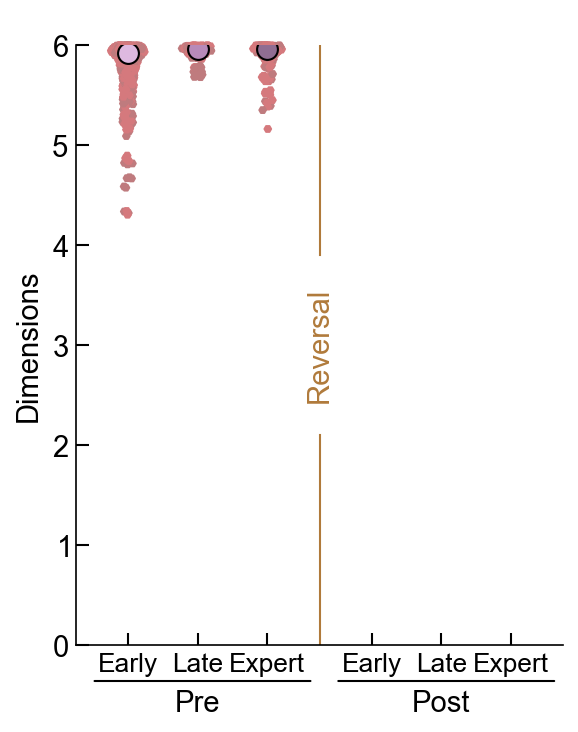

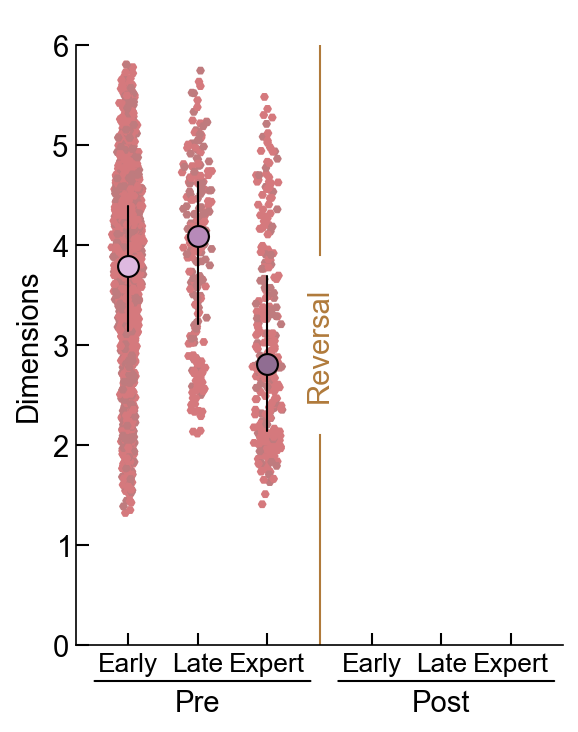

In [112]:
bin_lengths = [25,50,100]
sizes = [5,10,15]
profiles = ['all','CR','Mixed','NCR']
metrics = ['d_var','d_covar','d_GT']

profiles=['Mixed']
# for b,m in product(bin_lengths,metrics):
#     try:
#         plotFigure(b,10,m)
#     except:
#         pass
    
for p,m in product(profiles,metrics):
    try:
        plotFigureOpto(50,6,m,profiles=p)
    except Exception as e:
        print(e)
        raise e

# Opto vs Control

In [146]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def plotFigureCollapseOpto(bin_length,size_of_ensembles,metric,profiles='all'):
    fig,ax = make_axis_size(1.25, 4, left=.3, bottom=.3, right=0, top=0)
    switch_offset = 0.25

    ################################################################################################################
    # Opto
    ################################################################################################################

    size = 10
    summary_size=100
    summary_width=1#0.75

    mn = 1.8
    spread = 2.5

    ###

    FRmod_baseline_median = 3.5
    phases = ['post early','post late','post expert']
    
    sessions_in_phase = []
    for idx,session in enumerate(EnumSessionOps):
        if EILphasesOps[idx] in phases:
            sessions_in_phase.append(session)

    temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,metric) for session in sessions_in_phase]
    temp = [t for t in temp if len(t)>0]
    temp = np.concatenate(temp)
    data = temp

    temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,'NCR_ratio') for session in sessions_in_phase]
    temp = [t for t in temp if len(t)>0]
    temp = np.concatenate(temp)
    data_NCR_ratio = temp
        
    ##############
    if profiles == 'CR':
        mask = np.less_equal(data_NCR_ratio,0.3)
    elif profiles == 'Mixed':
        mask = np.logical_and(np.greater_equal(data_NCR_ratio,0.5),np.less_equal(data_NCR_ratio,0.7))
    elif profiles == 'NCR':
        mask = np.greater_equal(data_NCR_ratio,0.8)
    else:
        mask = np.ones_like(data_NCR_ratio,dtype='bool')  
    data = data[mask]
    data_NCR_ratio = data_NCR_ratio[mask]
    ##############

    data = np.array(data)
    data_NCR_ratio = np.array(data_NCR_ratio)
    labels = ['Early','Late','Expert','Early','Late','Expert']
    numCon = len(data)

    ###
    X = np.ones_like(data)*0
    _,Y = ilep.violin((X),data,width=0.5,minjitter=0.075)
    X,_ = ilep.violin((X),np.log10(data),width=0.5,minjitter=0.075)
    colors = NCR_CR_cmap( (1-data_NCR_ratio) )

    ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

    #################################################################################################################
    # Control
    #################################################################################################################    
    
    size = 10
    summary_size=100
    summary_width=1#0.75

    mn = 3.5
    spread = 2.5

    ###

    FRmod_baseline_median = 3.5
    phases = ['post early','post late','post expert']
    
    sessions_in_phase = []
    for idx,session in enumerate(EnumSession):
        if EILphases[idx] in phases:
            sessions_in_phase.append(session)

    temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,metric) for session in sessions_in_phase]
    temp = [t for t in temp if len(t)>0]
    temp = np.concatenate(temp)
    datacontrol = temp

    temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,'NCR_ratio') for session in sessions_in_phase]
    temp = [t for t in temp if len(t)>0]
    temp = np.concatenate(temp)
    datacontrol_NCR_ratio = temp
        
    ##############
    if profiles == 'CR':
        mask = np.less_equal(datacontrol_NCR_ratio,0.3)
    elif profiles == 'Mixed':
        mask = np.logical_and(np.greater_equal(datacontrol_NCR_ratio,0.5),np.less_equal(datacontrol_NCR_ratio,0.7))
    elif profiles == 'NCR':
        mask = np.greater_equal(datacontrol_NCR_ratio,0.8)
    else:
        mask = np.ones_like(datacontrol_NCR_ratio,dtype='bool')  
    datacontrol = datacontrol[mask]
    datacontrol_NCR_ratio = datacontrol_NCR_ratio[mask]
    ##############

    datacontrol = np.array(datacontrol)
    datacontrol_NCR_ratio = np.array(datacontrol_NCR_ratio)
    labels = ['Early','Late','Expert','Early','Late','Expert']
    numCon = len(datacontrol)

    ###
    X = np.ones_like(datacontrol)*1
    _,Y = ilep.violin((X),datacontrol,width=0.5,minjitter=0.075)
    X,_ = ilep.violin((X),np.log10(datacontrol),width=0.5,minjitter=0.075)
    colors = NCR_CR_cmap( (1-datacontrol_NCR_ratio) )

    ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

    
    
    
    
    
    
    ################################################################################################################
    
    #Plot summary
    idx=0
    polarity=0
    column = ilep.rmnan(data)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    eye_color = PHASE_COLORS[idx]
    border_color = 'k'

    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    ax.scatter([idx+polarity*switch_offset], [median], ec=LASER_COLOR,fc=LASER_COLOR, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=LASER_COLOR, lw=summary_width, zorder=9, solid_capstyle='round')
    
    
    
    #Plot summary
    idx=1
    polarity=0
    column = ilep.rmnan(datacontrol)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    eye_color = PHASE_COLORS[idx]
    border_color = 'k'

    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    ax.scatter([idx+polarity*switch_offset], [median], ec='k',fc='white', s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    ################################################################################################################

    ax.set_ylim([0,6])
    ax.set_yticks([0,2,4,6])
    ax.set_ylabel('Dimensionality')
    
    ax.set_xlim([-0.5,1.5])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Opto','Control'])
    
    print(f"p = {mannwhitneyu(data,datacontrol).pvalue}")
    print(f"mean opto dimm   : {np.mean(data)}")
    print(f"mean control dimm: {np.mean(datacontrol)}")
    print()
    
    artists = []
    fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC opto vs control dimensionality '+profiles+' ensembles '+str(bin_length)+'ms size '+str(size_of_ensembles)+' '+metric+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

p = 0.0009241365881473028
mean opto dimm   : 3.929740766071476
mean control dimm: 4.000729619745301

p = 3.447331577052504e-05
mean opto dimm   : 5.874230723341547
mean control dimm: 5.889509212452941

p = 3.456042608633238e-05
mean opto dimm   : 3.845504029937967
mean control dimm: 3.9260692189783577



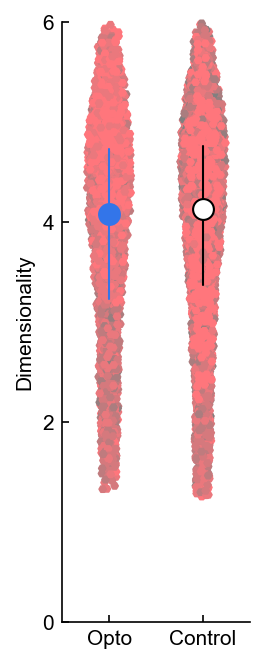

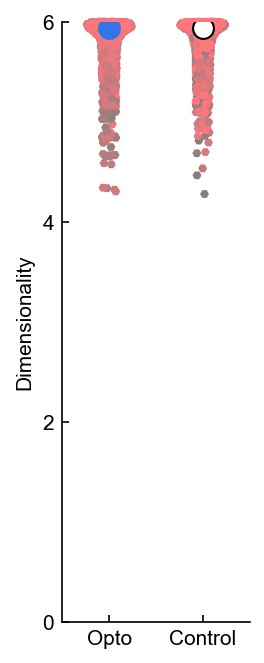

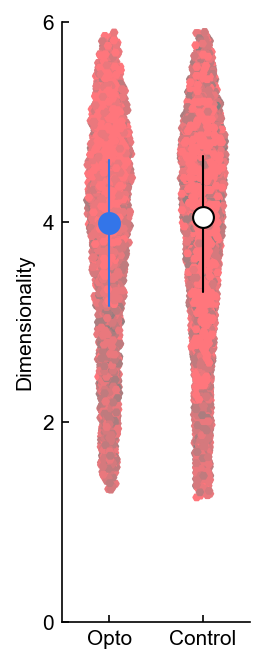

In [147]:
bin_lengths = [25,50,100]
sizes = [5,10,15]
profiles = ['all','CR','Mixed','NCR']
metrics = ['d_var','d_covar','d_GT']

profiles=['all']
    
for p,m in product(profiles,metrics):
    try:
        plotFigureCollapseOpto(50,6,m,profiles=p)
    except Exception as e:
        print(e)
        raise e

In [53]:
dim_df

,Unnamed: 0,bin_length,size,session,clust,sampling_coefficient,max_iters,d_var,d_covar,d_GT,FRmods,NCR_ratio,indiv
0,0,50.0,23,AE_238_10_AC.pickle,[ 7 17 18 26 35 38 48 49 52 55 58 ...,10,100,NaN,NaN,NaN,"[4.05466970387243, 1.67046317388003, 2.4601366...",0.652174,[nan nan nan nan nan nan nan nan nan nan nan n...
1,1,50.0,36,AE_238_11_AC.pickle,[ 5 15 21 41 48 51 55 68 76 84 86 ...,10,100,NaN,NaN,NaN,"[31.98924731182799, 4.289855072463769, 11.0984...",0.444444,[nan nan nan nan nan nan nan nan nan nan nan n...
2,2,50.0,54,AE_238_12_AC.pickle,[ 5 28 36 44 60 61 62 66 70 71 72 ...,10,100,NaN,NaN,NaN,"[2.202380952380951, 0.572597137014315, 0.61111...",0.796296,[nan nan nan nan nan nan nan nan nan nan nan n...
3,3,50.0,19,AE_238_13_AC.pickle,[ 1 4 9 22 23 24 31 32 51 53 75 ...,10,100,7.124886,18.584502,6.969076,"[2.1732745961820865, 0.2949852507374631, 1.671...",0.631579,[0.26318191 0.08925348 0.7378633 0.11476858 0...
4,4,50.0,15,AE_238_14_AC.pickle,[ 43 65 73 76 79 92 93 100 105 115 201 2...,10,100,NaN,NaN,NaN,"[1.098039215686274, 2.08627450980392, 0.679012...",0.800000,[nan nan nan nan nan nan nan nan nan nan nan n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409,50.0,23,DS_28_4_AC.pickle,[ 2 6 25 27 35 42 45 47 95 110 116 1...,10,100,NaN,NaN,NaN,"[1.5672514619883016, 10.293333333333337, 38.58...",0.608696,[nan nan nan nan nan nan nan nan nan nan nan n...
410,410,50.0,10,DS_28_5_AC.pickle,[ 0 2 8 10 11 33 38 40 42 46],10,100,3.933147,9.913848,3.899262,"[6.198439241917503, 0.2452619843924194, 2.6978...",0.800000,[0.20000059 0.11630279 0.21041514 0.11318847 0...
411,411,50.0,21,DS_28_6_AC.pickle,[ 0 2 6 7 26 27 28 30 34 36 49 50 51 52 57 ...,10,100,13.682059,20.672128,13.468442,"[1.5527065527065513, 0.7549857549857549, 2.108...",0.904762,[0.14870857 0.21702709 0.84023218 0.29095908 0...
412,412,50.0,32,DS_28_8_AC.pickle,[ 0 1 5 6 7 19 20 21 28 33 36 ...,10,100,NaN,NaN,NaN,"[2.1500000000000004, 0.5128205128205128, 0.716...",0.593750,[nan nan nan nan nan nan nan nan nan nan nan n...


In [55]:
s = list(dim_df['clust'][mask])[0]
s

'[  7  17  18  26  35  38  48  49  52  55  58  64  66  69  70  82  90  99\n 108 115 117 120 123]'

# Size_max vs Size_4

In [204]:
def getSMaxEnsembleData(session,df,threshold=10):
    mask = df['session'] == session
    assert np.sum(mask) <= 1
    ensemble = list(df['clust'][mask])[0]  #Note that this is a string and must be converted
    ensemble = np.array(ensemble.strip("[]").split())
    if len(ensemble) < threshold:
        return np.nan,np.nan,np.nan,np.nan
    
    d_var = list(df['d_var'][mask])[0] / len(ensemble)
    d_covar = list(df['d_covar'][mask])[0] / len(ensemble)
    d_GT = list(df['d_GT'][mask])[0] / len(ensemble)
    NCR = list(df['NCR_ratio'][mask])[0]
    return d_var,d_covar,d_GT,NCR

def getSmallEnsembleData(session,df):
    mask = df['session'] == session
    num = np.sum(mask)
    if num == 1:
        idx = 0
    elif num > 1:
        idx = np.random.randint(num)
    else:
        return np.nan,np.nan,np.nan,np.nan
    
    ensemble = list(df['clust'][mask])[idx]
    ensemble = np.array(ensemble.strip("[]").split())
        
    try:
        d_var = list(df['d_var'][mask])[idx] / len(ensemble)
        d_covar = list(df['d_covar'][mask])[idx] / len(ensemble)
        d_GT = list(df['d_GT'][mask])[idx] / len(ensemble)
        NCR = list(df['NCR_ratio'][mask])[0]
        return d_var,d_covar,d_GT,NCR
    except Exception as e:
        print(f"Error: {e}")
        return np.nan,np.nan,np.nan,np.nan

In [205]:
smax_d_var = []
s4_d_var = []
s6_d_var = []

smax_d_cov = []
s4_d_cov = []
s6_d_cov = []

smax_d_GT = []
s4_d_GT = []
s6_d_GT = []

smax_NCR = []
s4_NCR = []
s6_NCR = []

for session in EnumSession:
    a,b,c,d = getSMaxEnsembleData(session,dim_highIters_smax_df)
    smax_d_var.append(a)
    smax_d_cov.append(b)
    smax_d_GT.append(c)
    smax_NCR.append(d)
    
    a,b,c,d = getSmallEnsembleData(session,dim_highIters_s4_df)
    s4_d_var.append(a)
    s4_d_cov.append(b)
    s4_d_GT.append(c)
    s4_NCR.append(d)
     
    a,b,c,d = getSmallEnsembleData(session,dim_highIters_s6_df)
    s6_d_var.append(a)
    s6_d_cov.append(b)
    s6_d_GT.append(c)
    s6_NCR.append(d)

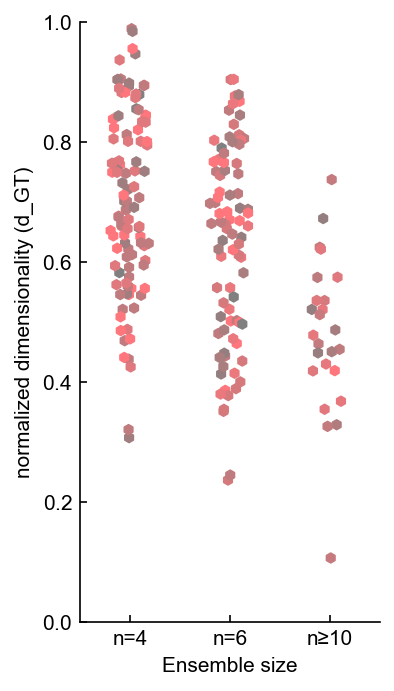

In [197]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

colors = NCR_CR_cmap( (1-np.array(s4_NCR)) )
colors2 = NCR_CR_cmap( (1-np.array(s6_NCR)) )
colors3 = NCR_CR_cmap( (1-np.array(smax_NCR)) )

X,Y = ilep.violin(s4_d_GT,width=0.5)
X2,Y2 = ilep.violin(s6_d_GT,width=0.5)
X3,Y3 = ilep.violin(smax_d_GT,width=0.5)
X2 = X2 + 1
X3 = X3 + 2

sz = 20
ax.scatter(X,Y,c=colors,s=sz,clip_on=False,marker='h')
ax.scatter(X2,Y2,c=colors2,s=sz,clip_on=False,marker='h')
ax.scatter(X3,Y3,c=colors3,s=sz,clip_on=False,marker='h')

ax.set_xlim([-0.5,2.5])
ax.set_ylim([0,1])
# ax.set_yticks([0.7,0.8,0.9,1])

ax.set_xticks([0,1,2])
ax.set_xticklabels(['n=4','n=6','n≥10'])
xlab = ax.set_xlabel('Ensemble size')

ylab = ax.set_ylabel('normalized dimensionality (d_GT)')
    
artists = [ylab]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC dimensionality size comparison d_GT V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
pass

In [160]:
p1 = mannwhitneyu(ilep.rmnan(s4_d_var),ilep.rmnan(s6_d_var)).pvalue
p2 = mannwhitneyu(ilep.rmnan(s6_d_var),ilep.rmnan(smax_d_var)).pvalue
p3 = mannwhitneyu(ilep.rmnan(s4_d_var),ilep.rmnan(smax_d_var)).pvalue

_,p_corr = pg.multicomp([p1,p2,p3],method='fdr_bh')
p_corr

array([2.41740802e-02, 7.79493484e-04, 1.58138144e-06])

In [161]:
p1 = mannwhitneyu(ilep.rmnan(s4_d_cov),ilep.rmnan(s6_d_cov)).pvalue
p2 = mannwhitneyu(ilep.rmnan(s6_d_cov),ilep.rmnan(smax_d_cov)).pvalue
p3 = mannwhitneyu(ilep.rmnan(s4_d_cov),ilep.rmnan(smax_d_cov)).pvalue

_,p_corr = pg.multicomp([p1,p2,p3],method='fdr_bh')
p_corr

array([2.51967536e-03, 1.02892129e-07, 8.88372974e-10])

In [162]:
p1 = mannwhitneyu(ilep.rmnan(s4_d_GT),ilep.rmnan(s6_d_GT)).pvalue
p2 = mannwhitneyu(ilep.rmnan(s6_d_GT),ilep.rmnan(smax_d_GT)).pvalue
p3 = mannwhitneyu(ilep.rmnan(s4_d_GT),ilep.rmnan(smax_d_GT)).pvalue

_,p_corr = pg.multicomp([p1,p2,p3],method='fdr_bh')
p_corr

array([2.00159229e-02, 4.43563218e-05, 4.11636152e-08])

In [15]:
import random

In [20]:
session = random.sample(os.listdir(act_directory),1)[0]
session

'BS_41_11_AC.pickle'

In [26]:
ensembles = ilep.getPossibleCombinationsAZ(sessionfile,'NO_TRIM',minClust=10,MaxClust=10,MaxSample=len(sessionfile.clusters.good)*5,verbose=True)#findMoreEnsembles(sessionfile,search_iterations=100)

DS_24_8_AC find enough trial for ensemble 10
DS_24_8_AC find enough trial in 1 iterations


In [28]:
ensembles[0]

[3, 31, 32, 42, 49, 58, 85, 87, 89, 91]

In [22]:
def calculateDimensionalityParallel(session,directory,bin_length_msec=50):
    sessionfile = ilep.loadSessionCached(directory,session)
    with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)
    ensembles = ilep.getPossibleCombinationsAZ(sessionfile,trialsPerDayLoaded,minClust=10,MaxClust=10,MaxSample=len(sessionfile.clusters.good)*5,verbose=True)#findMoreEnsembles(sessionfile,search_iterations=100)
    n_ensembles = len(ensembles)
    
    if n_ensembles == 0:
        print('Aborting, n_ensembles = 0')
        return ([],[],[],[],[])
    
    d_var_list,d_covar_list,d_GT_list,NCR_ratio_list = [],[],[],[]
    for ensemble in ensembles:
        print(ensemble)
        
        d_var,d_covar,d_GT = ilep.calculate_dimensionality(sessionfile,ensemble,bin_length_msec=bin_length_msec)
        d_var_list.append(d_var)
        d_covar_list.append(d_covar)
        d_GT_list.append(d_GT)
        
        FRmods = [sessionfile.responsiveness[clust]['all_trials'].FRmodulation for clust in ensemble]
        NCR_ratio = np.mean(np.less(FRmods,3.5))
        NCR_ratio_list.append(NCR_ratio)
        
    return ([session]*n_ensembles,d_var_list,d_covar_list,d_GT_list,NCR_ratio_list)

In [23]:
calculateDimensionalityParallel(session,act_directory)

BS_41_11_AC find enough trial for ensemble 10
BS_41_11_AC find enough trial in 1 iterations
[0, 3, 4, 6, 10, 11, 14, 15, 75, 79]
[3, 6, 9, 11, 14, 18, 19, 56, 75, 79]
[0, 6, 8, 9, 11, 14, 15, 18, 19, 79]
[0, 4, 6, 9, 10, 11, 14, 18, 19, 52]
[4, 6, 9, 11, 15, 18, 19, 52, 56, 79]
[0, 3, 6, 10, 11, 14, 15, 56, 75, 79]
[0, 3, 4, 8, 10, 15, 19, 52, 56, 75]
[4, 6, 8, 9, 10, 11, 15, 18, 19, 52]
[3, 8, 9, 10, 15, 18, 19, 52, 75, 79]
[0, 4, 6, 8, 11, 15, 18, 19, 52, 56]
[0, 3, 6, 8, 9, 18, 19, 52, 56, 75]
[0, 3, 9, 10, 11, 15, 52, 56, 75, 79]
[3, 4, 6, 9, 10, 15, 18, 56, 75, 79]
[0, 3, 8, 9, 15, 18, 52, 56, 75, 79]
[0, 4, 6, 8, 9, 11, 14, 18, 52, 75]
[4, 8, 9, 10, 14, 15, 18, 52, 56, 79]
[0, 3, 4, 6, 8, 11, 15, 19, 52, 75]
[0, 4, 8, 9, 10, 14, 18, 52, 75, 79]
[0, 3, 9, 11, 15, 18, 19, 52, 56, 75]
[3, 4, 6, 8, 9, 11, 14, 18, 52, 56]
[0, 3, 4, 11, 14, 18, 19, 52, 56, 75]
[6, 8, 9, 10, 11, 14, 15, 18, 52, 79]
[0, 3, 4, 8, 10, 15, 19, 52, 75, 79]
[0, 3, 4, 6, 10, 14, 15, 52, 75, 79]
[4, 8, 9, 11, 1

KeyboardInterrupt: 

In [7]:
sessionfile = ilep.getRandomSession(act_directory)
sessionfile.clusters.good

array([ 2,  3, 31, 32, 42, 49, 58, 71, 85, 87, 89, 91, 98], dtype=int64)

In [8]:
ilep.getPossibleCombinationsAZ(sessionfile,'NO_TRIM',minClust=10,MaxClust=10,MaxSample=len(sessionfile.clusters.good)*5,verbose=True)

DS_24_8_AC find enough trial for ensemble 10
DS_24_8_AC find enough trial in 1 iterations


[[2, 3, 32, 42, 49, 58, 71, 87, 89, 98],
 [2, 3, 32, 42, 58, 71, 85, 87, 91, 98],
 [2, 3, 31, 32, 42, 49, 58, 71, 91, 98],
 [2, 31, 32, 42, 49, 71, 85, 89, 91, 98],
 [2, 3, 31, 42, 49, 85, 87, 89, 91, 98],
 [3, 31, 32, 42, 49, 58, 71, 87, 89, 91],
 [2, 3, 31, 32, 42, 58, 85, 87, 89, 91],
 [3, 31, 32, 49, 58, 71, 87, 89, 91, 98],
 [2, 3, 31, 42, 49, 58, 71, 87, 91, 98],
 [2, 3, 31, 32, 42, 49, 58, 71, 89, 98],
 [2, 42, 49, 58, 71, 85, 87, 89, 91, 98],
 [3, 31, 32, 49, 58, 71, 85, 87, 89, 91],
 [2, 3, 31, 32, 49, 58, 71, 85, 87, 91],
 [2, 3, 31, 32, 42, 58, 71, 87, 91, 98],
 [2, 3, 31, 42, 49, 58, 71, 89, 91, 98],
 [2, 31, 42, 49, 58, 71, 85, 87, 91, 98],
 [2, 3, 31, 32, 42, 49, 58, 71, 89, 91],
 [2, 3, 32, 42, 49, 58, 71, 85, 91, 98],
 [3, 31, 32, 49, 58, 71, 87, 89, 91, 98],
 [2, 31, 32, 42, 58, 71, 85, 87, 89, 91],
 [2, 3, 31, 42, 58, 71, 85, 87, 89, 91],
 [2, 3, 31, 42, 49, 58, 71, 85, 87, 89],
 [2, 3, 31, 49, 58, 71, 85, 87, 91, 98],
 [2, 31, 32, 42, 58, 71, 85, 87, 91, 98],
 [2, 3,

In [8]:
sessions_exp = np.array(EnumSession)[EILphases == 'pre expert']

In [130]:
for session in sessions_exp:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    print(f"session {session} has {len(sessionfile.clusters.good)} clusters")
    if len(sessionfile.clusters.good) >= 10:
        
        print(len(ilep.getAllConditions(sessionfile,None)['all_trials'].trials))

session BS_108_1_AC.pickle has 6 clusters
session BS_108_2_AC.pickle has 4 clusters
session BS_40_12_AC.pickle has 19 clusters
53
session BS_49_12_AC.pickle has 6 clusters
session BS_70_3_AC.pickle has 0 clusters
session BS_72_1_AC.pickle has 19 clusters
211
session BS_72_2_AC.pickle has 12 clusters
170
session BS_87_1_AC.pickle has 8 clusters
session BS_87_2_AC.pickle has 1 clusters
session DS_15_1_AC.pickle has 27 clusters
167
session DS_19_1_AC.pickle has 15 clusters
423


In [136]:
session = 'DS_15_1_AC.pickle'

In [131]:
sessions = np.unique(EnumSession)
directories = [act_directory]*len(sessions)

In [133]:
session_list

array(['BS_108_3_AC.pickle', 'BS_108_3_AC.pickle', 'BS_108_3_AC.pickle',
       'BS_108_6_AC.pickle', 'BS_108_6_AC.pickle', 'BS_40_10_AC.pickle',
       'BS_40_14_AC.pickle', 'BS_40_14_AC.pickle', 'BS_40_15_AC.pickle',
       'BS_40_16_AC.pickle', 'BS_40_19_AC.pickle', 'BS_40_2_AC.pickle',
       'BS_40_2_AC.pickle', 'BS_40_2_AC.pickle', 'BS_40_2_AC.pickle',
       'BS_40_2_AC.pickle', 'BS_40_3_AC.pickle', 'BS_40_3_AC.pickle',
       'BS_40_6_AC.pickle', 'BS_41_11_AC.pickle', 'BS_41_1_AC.pickle',
       'BS_41_1_AC.pickle', 'BS_41_1_AC.pickle', 'BS_41_4_AC.pickle',
       'BS_41_4_AC.pickle', 'BS_41_7_AC.pickle', 'BS_41_8_AC.pickle',
       'BS_41_9_AC.pickle', 'BS_42_1_AC.pickle', 'BS_42_2_AC.pickle',
       'BS_42_2_AC.pickle', 'BS_42_2_AC.pickle', 'BS_42_3_AC.pickle',
       'BS_42_3_AC.pickle', 'BS_42_3_AC.pickle', 'BS_42_4_AC.pickle',
       'BS_42_4_AC.pickle', 'BS_42_4_AC.pickle', 'BS_42_5_AC.pickle',
       'BS_42_6_AC.pickle', 'BS_42_7_AC.pickle', 'BS_42_7_AC.pickle',
       '

In [188]:
len(sessionfile.clusters.good)

31

In [200]:
findMoreEnsembles(sessionfile,search_iterations = 10)

D
3.6666666666666665


array([[134, 156, 143, 164, 138, 162,   4, 155,  48,  54],
       [  9,  90,  84, 143,   2,  49,  10,   6, 138, 164],
       [ 78,  57, 164, 138,  10,  84, 142,  90,   2,   4],
       [162, 118,  10,   4, 128, 138,  78,   3,  54,  96]], dtype=int64)

In [7]:
def findMoreEnsembles(sessionfile,ensemble_size = 10,search_iterations = 1000, min_intersection_trials = 100):
    clusters = []
    for clust in sessionfile.clusters.good:
        AllConds = ilep.getAllConditions(sessionfile,clust)
        if len(AllConds['all_trials'].trials) >= min_intersection_trials:
            clusters.append(clust)
    
    n = len(clusters)
    n_ensembles = int(np.floor(n / ensemble_size))
    if comb(n,n_ensembles) > 25*n_ensembles:
        print('D')
        n_ensembles *= 5
    elif comb(n,n_ensembles) > 16*n_ensembles:
        print('C')
        n_ensembles *= 4
    elif comb(n,n_ensembles) > 9*n_ensembles:
        print('B')
        n_ensembles *= 3
    elif comb(n,n_ensembles) > 4*n_ensembles:
        print('A')
        n_ensembles *= 2
    
    if n_ensembles == 0:
        print('No Ensembles at start of algorithm')
        return []
    
    best_ensembles = []
    current_n_ensembles = 0
    current_min_intersection = 0
    current_ensemble_intersection = 0
    current_mean_overlap = ensemble_size
    for iteration in range(search_iterations):
        
        ensembles = [[]]*n_ensembles
        for idx in range(n_ensembles):
            ensembles[idx] = np.random.choice(clusters,size=ensemble_size,replace=False)
        ensembles = np.array(ensembles)
        
        intersections = np.array([len(ilep.getAllConditions(sessionfile,ensembles[idx])['all_trials'].trials) for idx in range(n_ensembles)])
        
        valid_ensembles_mask = np.greater_equal(intersections,min_intersection_trials)
        valid_ensembles = ensembles[valid_ensembles_mask]
        n_valid_ensembles = np.sum(valid_ensembles_mask)
        if n_valid_ensembles == 0:
            continue
        min_intersection = np.min(intersections[valid_ensembles_mask])
        mean_intersection = np.mean(intersections[valid_ensembles_mask])
        
        overlaps = []
        for i,j in product(range(n_valid_ensembles),range(n_valid_ensembles)):
            if i == j:
                continue
            overlaps.append(np.sum(np.isin(valid_ensembles[i],valid_ensembles[j])))
        if len(overlaps) == 0:
            mean_overlap = 10
        else:
            mean_overlap = np.mean(overlaps)
        
        
        if n_valid_ensembles > current_n_ensembles:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            current_mean_overlap = mean_overlap
        elif n_valid_ensembles == current_n_ensembles and mean_overlap < current_mean_overlap:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            current_mean_overlap = mean_overlap
            
#         elif n_valid_ensembles == current_n_ensembles and min_intersection > current_min_intersection:
#             best_ensembles = valid_ensembles
#             current_n_ensembles = n_valid_ensembles
#             current_n_intersection = min_intersection
#             current_ensemble_intersection = mean_intersection
#             current_mean_overlap = mean_overlap
            
#         elif n_valid_ensembles == current_n_ensembles and min_intersection == current_min_intersection and mean_intersection > current_ensemble_intersection:
#             best_ensembles = valid_ensembles
#             current_n_ensembles = n_valid_ensembles
#             current_n_intersection = min_intersection
#             current_ensemble_intersection = mean_intersection
#             current_mean_overlap = mean_overlap
            
    if current_n_ensembles == 0:
        print('No Ensembles at end of algorithm')
        return []
    
    return best_ensembles

In [8]:
def findEnsembles(sessionfile,ensemble_size = 10,search_iterations = 1000, min_intersection_trials = 100):
    clusters = []
    for clust in sessionfile.clusters.good:
        AllConds = ilep.getAllConditions(sessionfile,clust)
        if len(AllConds['all_trials'].trials) >= min_intersection_trials:
            clusters.append(clust)
    
    n = len(clusters)
    n_ensembles = int(np.floor(n / ensemble_size))
    
    if n_ensembles == 0:
        print('No Ensembles at start of algorithm')
        return []
    
    best_ensembles = []
    current_n_ensembles = 0
    current_min_intersection = 0
    current_ensemble_intersection = 0
    for iteration in range(search_iterations):
        permuted_cells = np.random.permutation(clusters)
        
        ensembles = [[]]*n_ensembles
        for idx in range(n_ensembles):
            ensembles[idx] = permuted_cells[ range(idx*ensemble_size,idx*ensemble_size+ensemble_size) ]
        ensembles = np.array(ensembles)
        
        intersections = np.array([len(ilep.getAllConditions(sessionfile,ensembles[idx])['all_trials'].trials) for idx in range(n_ensembles)])
        
        valid_ensembles_mask = np.greater_equal(intersections,min_intersection_trials)
        valid_ensembles = ensembles[valid_ensembles_mask]
        n_valid_ensembles = np.sum(valid_ensembles_mask)
        if n_valid_ensembles == 0:
            continue
        min_intersection = np.min(intersections[valid_ensembles_mask])
        mean_intersection = np.mean(intersections[valid_ensembles_mask])
        
        
        if n_valid_ensembles > current_n_ensembles:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
        elif n_valid_ensembles == current_n_ensembles and min_intersection > current_min_intersection:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
        elif n_valid_ensembles == current_n_ensembles and min_intersection == current_min_intersection and mean_intersection > current_ensemble_intersection:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
    if current_n_ensembles == 0:
        print('No Ensembles at end of algorithm')
        return []
    
    return best_ensembles

In [9]:
def calculateDimensionalityParallel(session,directory):
    sessionfile = ilep.loadSessionCached(directory,session)
    ensembles = findEnsembles(sessionfile,search_iterations=100)
    n_ensembles = len(ensembles)
    
    if n_ensembles == 0:
        print('Aborting, n_ensembles = 0')
        return ([],[],[],[],[])
    
    d_var_list,d_covar_list,d_GT_list,NCR_ratio_list = [],[],[],[]
    for ensemble in ensembles:
        
        d_var,d_covar,d_GT = ilep.calculate_dimensionality(sessionfile,ensemble)
        d_var_list.append(d_var)
        d_covar_list.append(d_covar)
        d_GT_list.append(d_GT)
        
        FRmods = [sessionfile.responsiveness[clust]['all_trials'].FRmodulation for clust in ensemble]
        NCR_ratio = np.mean(np.less(FRmods,3.5))
        NCR_ratio_list.append(NCR_ratio)
        
    return ([session]*n_ensembles,d_var_list,d_covar_list,d_GT_list,NCR_ratio_list)

# Multi-threaded Operations

In [10]:
#rc = Client('/Users/balbanna/.starcluster/ipcluster/SecurityGroup:@sc-MI-us-east-1.json', sshkey='/Users/badr/.ssh/EC2key.rsa')
rc = Client()
dv = rc[:]
dv.block = True
dv.activate()
print("Number of active engines: {0}".format(len(dv)))

Number of active engines: 16


In [11]:
%%px --block
import InsanallyLabEphysTools as ilep
import numpy as np
from math import comb
from itertools import product

def findMoreEnsembles(sessionfile,ensemble_size = 10,search_iterations = 1000, min_intersection_trials = 100):
    clusters = []
    for clust in sessionfile.clusters.good:
        AllConds = ilep.getAllConditions(sessionfile,clust)
        if len(AllConds['all_trials'].trials) >= min_intersection_trials:
            clusters.append(clust)
    
    n = len(clusters)
    if n < ensemble_size:
        n_ensembles = 0
    elif n > ensemble_size + 5:
        n_ensembles = 25#n
    else:
        n_ensembles = 1
#     n_ensembles = int(np.floor(n / ensemble_size))
#     if comb(n,n_ensembles) > 100*n_ensembles:
#         n_ensembles *= 10
#     elif comb(n,n_ensembles) > 81*n_ensembles:
#         n_ensembles *= 9
#     elif comb(n,n_ensembles) > 64*n_ensembles:
#         n_ensembles *= 8
#     elif comb(n,n_ensembles) > 49*n_ensembles:
#         n_ensembles *= 7
#     elif comb(n,n_ensembles) > 36*n_ensembles:
#         n_ensembles *= 6
#     elif comb(n,n_ensembles) > 25*n_ensembles:
#         n_ensembles *= 5
#     elif comb(n,n_ensembles) > 16*n_ensembles:
#         n_ensembles *= 4
#     elif comb(n,n_ensembles) > 9*n_ensembles:
#         n_ensembles *= 3
#     elif comb(n,n_ensembles) > 4*n_ensembles:
#         n_ensembles *= 2
    
#     if n_ensembles == 0:
#         print('No Ensembles at start of algorithm')
#         return []
    
    best_ensembles = []
    current_n_ensembles = 0
    current_min_intersection = 0
    current_ensemble_intersection = 0
    current_mean_overlap = ensemble_size
    for iteration in range(search_iterations):
        
        ensembles = [[]]*n_ensembles
        for idx in range(n_ensembles):
            ensembles[idx] = np.random.choice(clusters,size=ensemble_size,replace=False)
        ensembles = np.array(ensembles)
        
        intersections = np.array([len(ilep.getAllConditions(sessionfile,ensembles[idx])['all_trials'].trials) for idx in range(n_ensembles)])
        
        valid_ensembles_mask = np.greater_equal(intersections,min_intersection_trials)
        valid_ensembles = ensembles[valid_ensembles_mask]
        n_valid_ensembles = np.sum(valid_ensembles_mask)
        if n_valid_ensembles == 0:
            continue
        min_intersection = np.min(intersections[valid_ensembles_mask])
        mean_intersection = np.mean(intersections[valid_ensembles_mask])
        
        overlaps = []
        for i,j in product(range(n_valid_ensembles),range(n_valid_ensembles)):
            if i == j:
                continue
            overlaps.append(np.sum(np.isin(valid_ensembles[i],valid_ensembles[j])))
        if len(overlaps) == 0:
            mean_overlap = 10
        else:
            mean_overlap = np.mean(overlaps)
        
        
        if n_valid_ensembles > current_n_ensembles:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            current_mean_overlap = mean_overlap
        elif n_valid_ensembles == current_n_ensembles and mean_overlap < current_mean_overlap:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            current_mean_overlap = mean_overlap
            
#         elif n_valid_ensembles == current_n_ensembles and min_intersection > current_min_intersection:
#             best_ensembles = valid_ensembles
#             current_n_ensembles = n_valid_ensembles
#             current_n_intersection = min_intersection
#             current_ensemble_intersection = mean_intersection
#             current_mean_overlap = mean_overlap
            
#         elif n_valid_ensembles == current_n_ensembles and min_intersection == current_min_intersection and mean_intersection > current_ensemble_intersection:
#             best_ensembles = valid_ensembles
#             current_n_ensembles = n_valid_ensembles
#             current_n_intersection = min_intersection
#             current_ensemble_intersection = mean_intersection
#             current_mean_overlap = mean_overlap
            
    if current_n_ensembles == 0:
        print('No Ensembles at end of algorithm')
        return []
    
    return best_ensembles

def findEnsembles(sessionfile,ensemble_size = 10,search_iterations = 1000, min_intersection_trials = 100):
    clusters = []
    for clust in sessionfile.clusters.good:
        AllConds = ilep.getAllConditions(sessionfile,clust)
        if len(AllConds['all_trials'].trials) >= min_intersection_trials:
            clusters.append(clust)
    
    n = len(clusters)
    n_ensembles = int(np.floor(n / ensemble_size))
    
    if n_ensembles == 0:
        print('No Ensembles at start of algorithm')
        return []
    
    best_ensembles = []
    current_n_ensembles = 0
    current_min_intersection = 0
    current_ensemble_intersection = 0
    for iteration in range(search_iterations):
        permuted_cells = np.random.permutation(clusters)
        
        ensembles = [[]]*n_ensembles
        for idx in range(n_ensembles):
            ensembles[idx] = permuted_cells[ range(idx*ensemble_size,idx*ensemble_size+ensemble_size) ]
        ensembles = np.array(ensembles)
        
        intersections = np.array([len(ilep.getAllConditions(sessionfile,ensembles[idx])['all_trials'].trials) for idx in range(n_ensembles)])
        
        valid_ensembles_mask = np.greater_equal(intersections,min_intersection_trials)
        valid_ensembles = ensembles[valid_ensembles_mask]
        n_valid_ensembles = np.sum(valid_ensembles_mask)
        if n_valid_ensembles == 0:
            continue
        min_intersection = np.min(intersections[valid_ensembles_mask])
        mean_intersection = np.mean(intersections[valid_ensembles_mask])
        
        
        if n_valid_ensembles > current_n_ensembles:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
        elif n_valid_ensembles == current_n_ensembles and min_intersection > current_min_intersection:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
        elif n_valid_ensembles == current_n_ensembles and min_intersection == current_min_intersection and mean_intersection > current_ensemble_intersection:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
    if current_n_ensembles == 0:
        print('No Ensembles at end of algorithm')
        return []
    
    return best_ensembles

#%load_ext autoreload
#%autoreload 2

%px: 100%|██████████| 16/16 [00:00<00:00, 21.60tasks/s]


In [12]:
def calculateDimensionalityParallel(session,directory,bin_length_msec=50):
    sessionfile = ilep.loadSessionCached(directory,session)
    ensembles = findMoreEnsembles(sessionfile,search_iterations=100)
    n_ensembles = len(ensembles)
    
    if n_ensembles == 0:
        print('Aborting, n_ensembles = 0')
        return ([],[],[],[],[])
    
    d_var_list,d_covar_list,d_GT_list,NCR_ratio_list = [],[],[],[]
    for ensemble in ensembles:
        
        d_var,d_covar,d_GT = ilep.calculate_dimensionality(sessionfile,ensemble,bin_length_msec=bin_length_msec)
        d_var_list.append(d_var)
        d_covar_list.append(d_covar)
        d_GT_list.append(d_GT)
        
        FRmods = [sessionfile.responsiveness[clust]['all_trials'].FRmodulation for clust in ensemble]
        NCR_ratio = np.mean(np.less(FRmods,3.5))
        NCR_ratio_list.append(NCR_ratio)
        
    return ([session]*n_ensembles,d_var_list,d_covar_list,d_GT_list,NCR_ratio_list)

In [23]:
calculateDimensionalityParallel(session,act_directory,bin_length_msec=25)

C


(['DS_15_3_AC.pickle',
  'DS_15_3_AC.pickle',
  'DS_15_3_AC.pickle',
  'DS_15_3_AC.pickle'],
 [6.226455112396192, 7.361592191397099, 6.364753843847089, 7.361610559611988],
 [9.79744605049611, 9.908234756510689, 9.904365892413724, 9.964970592788777],
 [6.100335804953736, 7.294038361405843, 6.303885088460823, 7.335823274209676],
 [0.3, 0.3, 0.5, 0.5])

In [22]:
session=sessions[120]

In [19]:
session

'BS_87_10_AC.pickle'

In [24]:
sessions = np.unique(EnumSession)
directories = [act_directory]*len(sessions)
# sessions = sessions[0:10]
# directories = directories[0:10]

In [ ]:
start_time = datetime.now()
print('Starting run at: '+str(start_time))

res = dv.map_sync(calculateDimensionalityParallel,sessions,directories)

end_time = datetime.now()
print('Elapsed time: '+str(end_time-start_time))

Starting run at: 2023-12-15 11:59:22.287419


In [12]:
session_list = []
d_var_list = []
d_covar_list = []
d_GT_list = []
NCR_ratio_list = []

for r in tqdm(res):
    sess,dvar,dcovar,dgt,dncr = r
    session_list.append(sess)
    d_var_list.append(dvar)
    d_covar_list.append(dcovar)
    d_GT_list.append(dgt)
    NCR_ratio_list.append(dncr)

session_list = np.concatenate((session_list))
d_var_list = np.concatenate((d_var_list))
d_covar_list = np.concatenate((d_covar_list))
d_GT_list = np.concatenate((d_GT_list))
NCR_ratio_list = np.concatenate((NCR_ratio_list))

100%|██████████| 145/145 [00:00<?, ?it/s]


In [13]:
EILphases = np.full_like(session_list,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(session_list)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 786/786 [00:15<00:00, 49.26it/s]

errors for: []


In [141]:
d_var_preearly = []
d_var_prelate = []
d_var_preexpert = []
d_var_postearly = []
d_var_postlate = []
d_var_postexpert = []

d_covar_preearly = []
d_covar_prelate = []
d_covar_preexpert = []
d_covar_postearly = []
d_covar_postlate = []
d_covar_postexpert = []

d_GT_preearly = []
d_GT_prelate = []
d_GT_preexpert = []
d_GT_postearly = []
d_GT_postlate = []
d_GT_postexpert = []

NCR_ratio_preearly = []
NCR_ratio_prelate = []
NCR_ratio_preexpert = []
NCR_ratio_postearly = []
NCR_ratio_postlate = []
NCR_ratio_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

for idx,(session,d_var,d_covar,d_GT,NCR_ratio) in tqdm(enumerate(zip(session_list,d_var_list,d_covar_list,d_GT_list,NCR_ratio_list))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        d_var_preearly.append(d_var)
        d_covar_preearly.append(d_covar)
        d_GT_preearly.append(d_GT)
        NCR_ratio_preearly.append(NCR_ratio)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        d_var_prelate.append(d_var)
        d_covar_prelate.append(d_covar)
        d_GT_prelate.append(d_GT)
        NCR_ratio_prelate.append(NCR_ratio)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        d_var_preexpert.append(d_var)
        d_covar_preexpert.append(d_covar)
        d_GT_preexpert.append(d_GT)
        NCR_ratio_preexpert.append(NCR_ratio)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        d_var_postearly.append(d_var)
        d_covar_postearly.append(d_covar)
        d_GT_postearly.append(d_GT)
        NCR_ratio_postearly.append(NCR_ratio)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        d_var_postlate.append(d_var)
        d_covar_postlate.append(d_covar)
        d_GT_postlate.append(d_GT)
        NCR_ratio_postlate.append(NCR_ratio)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        d_var_postexpert.append(d_var)
        d_covar_postexpert.append(d_covar)
        d_GT_postexpert.append(d_GT)
        NCR_ratio_postexpert.append(NCR_ratio)
        postexpert_animals.append(sessionfile.meta.animal)

d_var_preearly = np.array(d_var_preearly)
d_var_prelate = np.array(d_var_prelate)
d_var_preexpert = np.array(d_var_preexpert)
d_var_postearly = np.array(d_var_postearly)
d_var_postlate = np.array(d_var_postlate)
d_var_postexpert = np.array(d_var_postexpert)

d_covar_preearly = np.array(d_covar_preearly)
d_covar_prelate = np.array(d_covar_prelate)
d_covar_preexpert = np.array(d_covar_preexpert)
d_covar_postearly = np.array(d_covar_postearly)
d_covar_postlate = np.array(d_covar_postlate)
d_covar_postexpert = np.array(d_covar_postexpert)

d_GT_preearly = np.array(d_GT_preearly)
d_GT_prelate = np.array(d_GT_prelate)
d_GT_preexpert = np.array(d_GT_preexpert)
d_GT_postearly = np.array(d_GT_postearly)
d_GT_postlate = np.array(d_GT_postlate)
d_GT_postexpert = np.array(d_GT_postexpert)

NCR_ratio_preearly = np.array(NCR_ratio_preearly)
NCR_ratio_prelate = np.array(NCR_ratio_prelate)
NCR_ratio_preexpert = np.array(NCR_ratio_preexpert)
NCR_ratio_postearly = np.array(NCR_ratio_postearly)
NCR_ratio_postlate = np.array(NCR_ratio_postlate)
NCR_ratio_postexpert = np.array(NCR_ratio_postexpert)

NameError: name 'session_list' is not defined

# GT

NameError: name 'd_GT_preearly' is not defined

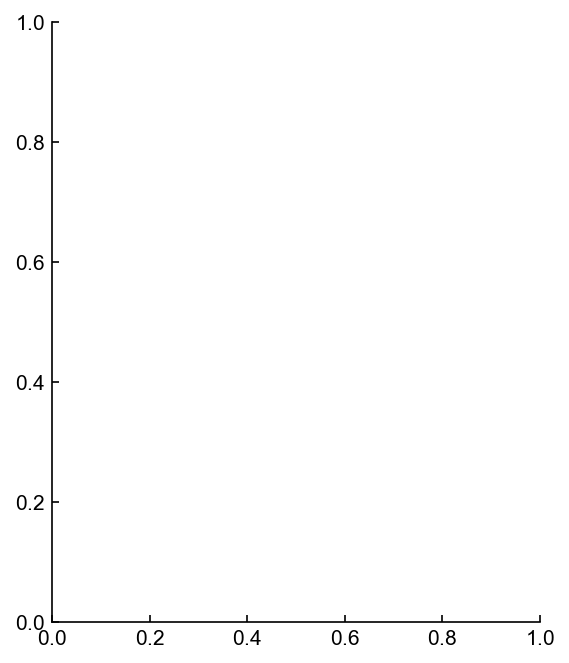

In [140]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [d_GT_preearly,d_GT_prelate,d_GT_preexpert,d_GT_postearly,d_GT_postlate,d_GT_postexpert]
data_NCR_ratio = np.concatenate([NCR_ratio_preearly,NCR_ratio_prelate,NCR_ratio_preexpert,NCR_ratio_postearly,NCR_ratio_postlate,NCR_ratio_postexpert])
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5,minjitter=0.075)
colors = NCR_CR_cmap( (1-data_NCR_ratio) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color = PHASE_COLORS[idx]
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,10])
ax.set_yticks([0,2,4,6,8,10])
ylab = ax.set_ylabel('Dimensions')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.3],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.3],lw=1,color=SWITCH_COLOR)

# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC dimensionality GT over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [16]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(d_GT_preearly)
data_dec.prelate = np.abs(d_GT_prelate)
data_dec.preexpert = np.abs(d_GT_preexpert)
data_dec.postearly = np.abs(d_GT_postearly)
data_dec.postlate = np.abs(d_GT_postlate)
data_dec.postexpert = np.abs(d_GT_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source           SS     DF         MS         F     p-unc  \
0            phase    38.369953    3.0  12.789984  6.735210  0.000173   
1          context     5.830245    1.0   5.830245  3.070209  0.080135   
2  phase * context    16.730297    3.0   5.576766  2.936726  0.032568   
3         Residual  1469.805445  774.0   1.898973       NaN       NaN   

        np2  
0  0.025441  
1  0.003951  
2  0.011255  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.209221  0.278962 -0.180257
8     post-late  baseline  experimental  0.005413  0.021651  0.229283
9    pre-expert  baseline  experimental  0.671562  0.671562  0.203742
10     pre-late  baseline  experimental  0.011541  0.023083  0.432579


# Variance

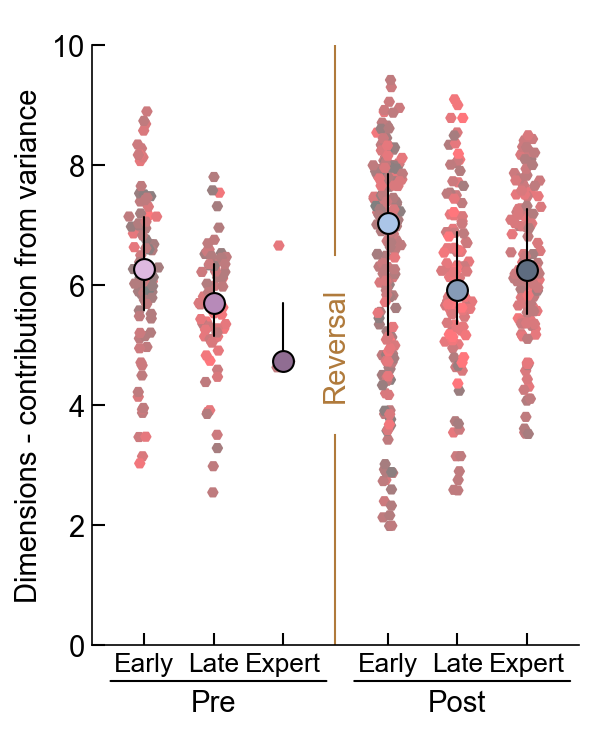

In [17]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [d_var_preearly,d_var_prelate,d_var_preexpert,d_var_postearly,d_var_postlate,d_var_postexpert]
data_NCR_ratio = np.concatenate([NCR_ratio_preearly,NCR_ratio_prelate,NCR_ratio_preexpert,NCR_ratio_postearly,NCR_ratio_postlate,NCR_ratio_postexpert])
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5,minjitter=0.075)
colors = NCR_CR_cmap( (1-data_NCR_ratio) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color = PHASE_COLORS[idx]
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,10])
ax.set_yticks([0,2,4,6,8,10])
ylab = ax.set_ylabel('Dimensions - contribution from variance')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.3],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.3],lw=1,color=SWITCH_COLOR)

# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC dimensionality variance over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [18]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(d_var_preearly)
data_dec.prelate = np.abs(d_var_prelate)
data_dec.preexpert = np.abs(d_var_preexpert)
data_dec.postearly = np.abs(d_var_postearly)
data_dec.postlate = np.abs(d_var_postlate)
data_dec.postexpert = np.abs(d_var_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source           SS     DF         MS         F     p-unc  \
0            phase    38.742689    3.0  12.914230  6.381646  0.000283   
1          context     9.342689    1.0   9.342689  4.616747  0.031971   
2  phase * context    22.521539    3.0   7.507180  3.709719  0.011421   
3         Residual  1566.306483  774.0   2.023652       NaN       NaN   

        np2  
0  0.024138  
1  0.005929  
2  0.014175  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.122589  0.163452 -0.192445
8     post-late  baseline  experimental  0.001340  0.004307  0.260817
9    pre-expert  baseline  experimental  0.589712  0.589712  0.272097
10     pre-late  baseline  experimental  0.002153  0.004307  0.499343


In [69]:
np.sum(EILphases=='pre expert')

9

# Covariance

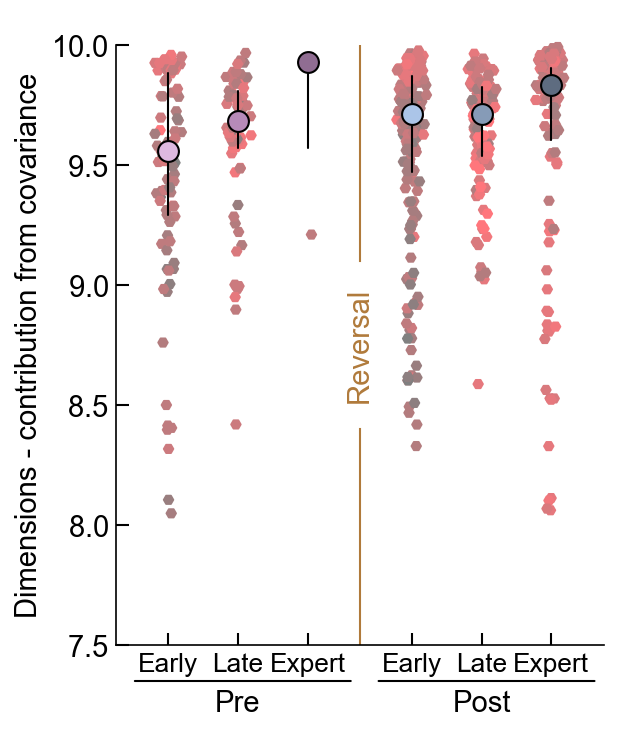

In [19]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [d_covar_preearly,d_covar_prelate,d_covar_preexpert,d_covar_postearly,d_covar_postlate,d_covar_postexpert]
data_NCR_ratio = np.concatenate([NCR_ratio_preearly,NCR_ratio_prelate,NCR_ratio_preexpert,NCR_ratio_postearly,NCR_ratio_postlate,NCR_ratio_postexpert])
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5,minjitter=0.075)
colors = NCR_CR_cmap( (1-data_NCR_ratio) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color = PHASE_COLORS[idx]
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([7.5,10])
ax.set_yticks([7.5,8,8.5,9,9.5,10])
ylab = ax.set_ylabel('Dimensions - contribution from covariance')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.04],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.04],lw=1,color=SWITCH_COLOR)

# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC dimensionality covariance over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [20]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(d_covar_preearly)
data_dec.prelate = np.abs(d_covar_prelate)
data_dec.preexpert = np.abs(d_covar_preexpert)
data_dec.postearly = np.abs(d_covar_postearly)
data_dec.postlate = np.abs(d_covar_postlate)
data_dec.postexpert = np.abs(d_covar_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source          SS     DF        MS         F     p-unc       np2
0            phase    1.018476    3.0  0.339492  2.534333  0.055767  0.009727
1          context    0.414410    1.0  0.414410  3.093601  0.078996  0.003981
2  phase * context    0.682339    3.0  0.227446  1.697903  0.166011  0.006538
3         Residual  103.682839  774.0  0.133957       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000931  0.003723  0.080190
8     post-late  baseline  experimental  0.938674  0.938674 -0.199976
9    pre-expert  baseline  experimental  0.283582  0.378109 -0.293307
10     pre-late  baseline  experimental  0.203900  0.378109 -0.331944


In [72]:
sessionfile = ilep.loadSessionCached(act_directory,'AE_229_7_passive_AC.pickle')

In [73]:
len(sessionfile.clusters.good)

36

In [16]:
sessions = os.listdir(act_directory)
session = np.random.choice(sessions)
print(session)

BS_33_13_AC.pickle


In [7]:
lastSession = None
#for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
for idx,(session) in tqdm(enumerate(np.unique(EnumSession))):
    #if session != lastSession:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    lastSession = session
    print(session)
    print(f"{len(sessionfile.clusters.good)} clusters")
    d_var,d_covar,d_GT = ilep.calculate_dimensionality(sessionfile)
    print()

0it [00:00, ?it/s]

BS_108_1_AC.pickle
6 clusters


1it [00:05,  5.80s/it]


BS_108_2_AC.pickle
4 clusters

BS_108_3_AC.pickle
31 clusters


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
../..\InsanallyLabEphysTools\analysis.py:612: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_mat = np.cov(rates)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
3it [01:11, 25.70s/it]


BS_108_4_AC.pickle
2 clusters


4it [01:15, 18.30s/it]


BS_108_6_AC.pickle
22 clusters


7it [01:47, 11.72s/it]


BS_40_10_AC.pickle
17 clusters

BS_40_12_AC.pickle
19 clusters

BS_40_14_AC.pickle
23 clusters


8it [01:47,  8.74s/it]


BS_40_15_AC.pickle
12 clusters


9it [03:00, 26.04s/it]


BS_40_16_AC.pickle
11 clusters


10it [03:16, 23.36s/it]


BS_40_18_AC.pickle
6 clusters


14it [04:15, 15.01s/it]


BS_40_19_AC.pickle
13 clusters

BS_40_21_AC.pickle
12 clusters

BS_40_22_AC.pickle
5 clusters

BS_40_2_AC.pickle
55 clusters


16it [04:15,  9.89s/it]


BS_40_3_AC.pickle
29 clusters

BS_40_4_AC.pickle
8 clusters


17it [04:39, 12.70s/it]


BS_40_5_AC.pickle
4 clusters


18it [04:50, 12.41s/it]


BS_40_6_AC.pickle
10 clusters


19it [06:10, 28.38s/it]


BS_40_7_AC.pickle
4 clusters


20it [06:33, 27.12s/it]


BS_40_8_AC.pickle
8 clusters


21it [06:46, 23.30s/it]


BS_41_10_AC.pickle
1 clusters
Too few neurons to calculate dimensionality for BS_41_10_AC_8-19-2021: 1 cells

BS_41_11_AC.pickle
16 clusters


23it [07:42, 25.46s/it]


BS_41_1_AC.pickle
38 clusters


26it [07:53, 13.18s/it]


BS_41_2_AC.pickle
10 clusters

BS_41_4_AC.pickle
29 clusters

BS_41_5_AC.pickle
9 clusters

BS_41_6_AC.pickle
5 clusters


30it [08:10,  7.46s/it]


BS_41_7_AC.pickle
16 clusters

BS_41_8_AC.pickle
20 clusters

BS_41_9_AC.pickle
13 clusters

BS_42_10_AC.pickle
9 clusters

BS_42_11_AC.pickle
3 clusters


35it [08:15,  3.61s/it]


BS_42_1_AC.pickle
18 clusters

BS_42_2_AC.pickle
39 clusters

BS_42_3_AC.pickle
30 clusters

BS_42_4_AC.pickle
30 clusters


37it [08:39,  6.02s/it]


BS_42_5_AC.pickle
13 clusters


40it [09:02,  5.97s/it]


BS_42_6_AC.pickle
26 clusters

BS_42_7_AC.pickle
31 clusters

BS_42_8_AC.pickle
2 clusters

BS_42_9_AC.pickle
2 clusters


42it [09:15,  6.16s/it]


BS_49_10_AC.pickle
1 clusters
Too few neurons to calculate dimensionality for BS_49_10_AC_9-15-2021: 1 cells

BS_49_12_AC.pickle
6 clusters


44it [09:37,  7.73s/it]


BS_49_14_AC.pickle
2 clusters


45it [09:43,  7.43s/it]


BS_49_16_AC.pickle
3 clusters


46it [09:48,  6.97s/it]


BS_49_1_AC.pickle
52 clusters


47it [10:07,  9.61s/it]


BS_49_2_AC.pickle
31 clusters

BS_49_4_AC.pickle
27 clusters


49it [10:25,  9.46s/it]


BS_49_5_AC.pickle
5 clusters


50it [10:27,  7.82s/it]


BS_49_6_AC.pickle
2 clusters


51it [10:29,  6.36s/it]


BS_49_7_AC.pickle
2 clusters


52it [10:29,  4.84s/it]


BS_49_9_AC.pickle
15 clusters


53it [10:33,  4.48s/it]


BS_50_2_AC.pickle
21 clusters


54it [10:53,  8.77s/it]


BS_50_3_AC.pickle
12 clusters


55it [10:58,  7.81s/it]


BS_50_7_AC.pickle
6 clusters


56it [11:40, 17.52s/it]


BS_51_2_AC.pickle
4 clusters


57it [11:42, 13.10s/it]


BS_56_1_AC.pickle
10 clusters

BS_56_2_AC.pickle
1 clusters
Too few neurons to calculate dimensionality for BS_56_2_AC_10-22-2021: 1 cells

BS_56_3_AC.pickle
8 clusters


60it [12:25, 13.74s/it]


BS_56_4_AC.pickle
2 clusters


61it [12:31, 12.04s/it]


BS_56_7_AC.pickle
2 clusters
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active

62it [12:44, 12.25s/it]


BS_67_1_AC.pickle
7 clusters

BS_67_2_AC.pickle
11 clusters

BS_67_3_AC.pickle
1 clusters
Too few neurons to calculate dimensionality for BS_67_3_AC_11-19-2021: 1 cells

BS_70_10_AC.pickle
9 clusters


66it [13:40, 13.34s/it]


BS_70_11_AC.pickle
9 clusters


67it [14:21, 17.96s/it]


BS_70_12_AC.pickle
5 clusters


68it [15:06, 23.22s/it]


BS_70_13_AC.pickle
3 clusters


69it [15:18, 20.70s/it]


BS_70_1_AC.pickle
27 clusters

BS_70_4_AC.pickle
2 clusters


71it [15:29, 14.87s/it]


BS_70_5_AC.pickle
4 clusters


72it [16:48, 28.75s/it]


BS_70_6_AC.pickle
14 clusters


73it [16:50, 22.39s/it]


BS_70_7_AC.pickle
8 clusters


74it [17:02, 19.95s/it]


BS_70_8_AC.pickle
15 clusters


75it [19:00, 45.76s/it]


BS_70_9_AC.pickle
16 clusters


76it [20:44, 61.72s/it]


BS_72_10_AC.pickle
7 clusters


77it [20:54, 47.24s/it]


BS_72_12_AC.pickle
2 clusters


78it [20:57, 34.38s/it]


BS_72_13_AC.pickle
4 clusters


79it [21:03, 26.16s/it]


BS_72_1_AC.pickle
19 clusters

BS_72_2_AC.pickle
12 clusters

BS_72_3_AC.pickle
12 clusters


82it [21:34, 17.49s/it]


BS_72_4_AC.pickle
25 clusters

BS_72_5_AC.pickle
15 clusters


84it [24:39, 43.34s/it]


BS_72_6_AC.pickle
23 clusters

BS_72_7_AC.pickle
8 clusters


86it [25:20, 35.84s/it]


BS_72_8_AC.pickle
10 clusters


87it [25:26, 30.09s/it]


BS_72_9_AC.pickle
3 clusters


88it [25:28, 24.14s/it]


BS_87_10_AC.pickle
1 clusters
Too few neurons to calculate dimensionality for BS_87_10_AC_2-8-2022: 1 cells

BS_87_11_AC.pickle
5 clusters

BS_87_12_AC.pickle
4 clusters


91it [25:39, 14.22s/it]


BS_87_1_AC.pickle
8 clusters


92it [25:54, 14.52s/it]


BS_87_2_AC.pickle
1 clusters
Too few neurons to calculate dimensionality for BS_87_2_AC_1-27-2022: 1 cells

BS_87_4_AC.pickle
40 clusters

BS_87_5_AC.pickle
29 clusters


95it [26:14, 10.93s/it]


BS_87_6_AC.pickle
16 clusters


96it [27:29, 22.06s/it]


BS_87_7_AC.pickle
3 clusters


97it [27:32, 18.37s/it]


BS_87_8_AC.pickle
9 clusters


100it [27:39,  9.68s/it]


BS_87_9_AC.pickle
28 clusters

DS_15_11_AC.pickle
25 clusters

DS_15_12_AC.pickle
13 clusters


103it [28:39, 12.75s/it]


DS_15_13_AC.pickle
25 clusters

DS_15_14_AC.pickle
31 clusters

DS_15_15_AC.pickle
28 clusters



107it [28:39,  5.51s/it]

DS_15_16_AC.pickle
20 clusters

DS_15_17_AC.pickle
15 clusters

DS_15_1_AC.pickle
27 clusters

DS_15_2_AC.pickle
6 clusters


109it [28:39,  3.75s/it]


DS_15_3_AC.pickle
19 clusters

DS_15_4_AC.pickle
5 clusters

DS_15_5_AC.pickle
3 clusters


114it [28:43,  1.91s/it]


DS_15_6_AC.pickle
16 clusters

DS_15_7_AC.pickle
6 clusters

DS_15_8_AC.pickle
10 clusters

DS_15_9_AC.pickle
20 clusters

DS_19_10_AC.pickle
4 clusters


116it [28:53,  2.76s/it]


DS_19_11_AC.pickle
6 clusters


117it [29:06,  4.37s/it]


DS_19_12_AC.pickle
2 clusters


118it [29:21,  6.34s/it]


DS_19_14_AC.pickle
9 clusters

DS_19_16_AC.pickle
23 clusters

DS_19_18_AC.pickle
5 clusters


121it [29:41,  6.49s/it]


DS_19_19_AC.pickle
8 clusters


122it [30:08, 10.24s/it]


DS_19_1_AC.pickle
15 clusters


123it [30:24, 11.39s/it]


DS_19_20_AC.pickle
3 clusters


125it [30:33,  8.15s/it]


DS_19_2_AC.pickle
24 clusters



127it [30:33,  4.85s/it]

DS_19_3_AC.pickle
26 clusters

DS_19_4_AC.pickle
19 clusters

DS_19_5_AC.pickle
32 clusters



129it [30:33,  3.09s/it]

DS_19_6_AC.pickle
40 clusters

DS_19_7_AC.pickle
19 clusters


131it [30:55,  5.47s/it]


DS_19_8_AC.pickle
31 clusters

DS_19_9_AC.pickle
7 clusters


132it [31:12, 14.18s/it]

In [12]:
dim_var_preearly = []
dim_var_prelate = []
dim_var_preexpert = []
dim_var_postearly = []
dim_var_postlate = []
dim_var_postexpert = []

dim_covar_preearly = []
dim_covar_prelate = []
dim_covar_preexpert = []
dim_covar_postearly = []
dim_covar_postlate = []
dim_covar_postexpert = []

dim_GT_preearly = []
dim_GT_prelate = []
dim_GT_preexpert = []
dim_GT_postearly = []
dim_GT_postlate = []
dim_GT_postexpert = []

dim_max_preearly = []
dim_max_prelate = []
dim_max_preexpert = []
dim_max_postearly = []
dim_max_postlate = []
dim_max_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session) in tqdm(enumerate(np.unique(EnumSession))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    dim_var,dim_covar,dim_GT = ilep.calculate_dimensionality(sessionfile)
    dim_max = len(sessionfile.clusters.good)
        
    if EILphases[idx] == 'pre early':
        dim_var_preearly.append(dim_var)
        dim_covar_preearly.append(dim_covar)
        dim_GT_preearly.append(dim_GT)
        dim_max_preearly.append(dim_max)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        dim_var_prelate.append(dim_var)
        dim_covar_prelate.append(dim_covar)
        dim_GT_prelate.append(dim_GT)
        dim_max_prelate.append(dim_max)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        dim_var_preexpert.append(dim_var)
        dim_covar_preexpert.append(dim_covar)
        dim_GT_preexpert.append(dim_GT)
        dim_max_preexpert.append(dim_max)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        dim_var_postearly.append(dim_var)
        dim_covar_postearly.append(dim_covar)
        dim_GT_postearly.append(dim_GT)
        dim_max_postearly.append(dim_max)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        dim_var_postlate.append(dim_var)
        dim_covar_postlate.append(dim_covar)
        dim_GT_postlate.append(dim_GT)
        dim_max_postlate.append(dim_max)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        dim_var_postexpert.append(dim_var)
        dim_covar_postexpert.append(dim_covar)
        dim_GT_postexpert.append(dim_GT)
        dim_max_postexpert.append(dim_max)
        postexpert_animals.append(sessionfile.meta.animal)

dim_var_preearly = np.array(dim_var_preearly)
dim_var_prelate = np.array(dim_var_prelate)
dim_var_preexpert = np.array(dim_var_preexpert)
dim_var_postearly = np.array(dim_var_postearly)
dim_var_postlate = np.array(dim_var_postlate)
dim_var_postexpert = np.array(dim_var_postexpert)

dim_covar_preearly = np.array(dim_covar_preearly)
dim_covar_prelate = np.array(dim_covar_prelate)
dim_covar_preexpert = np.array(dim_covar_preexpert)
dim_covar_postearly = np.array(dim_covar_postearly)
dim_covar_postlate = np.array(dim_covar_postlate)
dim_covar_postexpert = np.array(dim_covar_postexpert)

dim_GT_preearly = np.array(dim_GT_preearly)
dim_GT_prelate = np.array(dim_GT_prelate)
dim_GT_preexpert = np.array(dim_GT_preexpert)
dim_GT_postearly = np.array(dim_GT_postearly)
dim_GT_postlate = np.array(dim_GT_postlate)
dim_GT_postexpert = np.array(dim_GT_postexpert)

dim_max_preearly = np.array(dim_max_preearly)
dim_max_prelate = np.array(dim_max_prelate)
dim_max_preexpert = np.array(dim_max_preexpert)
dim_max_postearly = np.array(dim_max_postearly)
dim_max_postlate = np.array(dim_max_postlate)
dim_max_postexpert = np.array(dim_max_postexpert)

8it [01:47,  9.41s/it]

Too few neurons to calculate dimensionality for BS_40_11_AC_8-18-2021: 0 cells
Too few neurons to calculate dimensionality for BS_40_13_AC_8-20-2021: 0 cells


23it [06:45, 23.00s/it]

Too few neurons to calculate dimensionality for BS_41_10_AC_8-19-2021: 1 cells


29it [07:53, 10.92s/it]

Too few neurons to calculate dimensionality for BS_41_3_AC_8-9-2021: 0 cells


45it [09:14,  6.37s/it]

Too few neurons to calculate dimensionality for BS_49_10_AC_9-15-2021: 1 cells


47it [09:37,  7.98s/it]

Too few neurons to calculate dimensionality for BS_49_13_AC_9-20-2021: 0 cells


49it [09:43,  6.41s/it]

Too few neurons to calculate dimensionality for BS_49_15_AC_9-22-2021: 0 cells


58it [10:33,  4.27s/it]

Too few neurons to calculate dimensionality for BS_50_10_AC_9-23-2021: 0 cells
Too few neurons to calculate dimensionality for BS_50_11_AC_9-23-2021: 0 cells


62it [10:58,  5.49s/it]

Too few neurons to calculate dimensionality for BS_50_4_AC_9-15-2021: 0 cells
Too few neurons to calculate dimensionality for BS_50_6_AC_9-17-2021: 0 cells


66it [11:42,  8.14s/it]

Too few neurons to calculate dimensionality for BS_51_3_AC_10-15-2021: 0 cells
Too few neurons to calculate dimensionality for BS_56_2_AC_10-22-2021: 1 cells


71it [12:31,  8.87s/it]

session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust [ 4 12] tried to load saved active trials but failed. Error: 22


72it [12:44,  9.63s/it]

Too few neurons to calculate dimensionality for BS_67_3_AC_11-19-2021: 1 cells


79it [15:19, 19.54s/it]

Too few neurons to calculate dimensionality for BS_70_3_AC_11-23-2021: 0 cells


88it [20:57, 45.58s/it]

Too few neurons to calculate dimensionality for BS_72_11_AC_12-9-2021: 0 cells


100it [25:31, 24.35s/it]

Too few neurons to calculate dimensionality for BS_87_10_AC_2-8-2022: 1 cells


106it [25:57,  9.36s/it]

Too few neurons to calculate dimensionality for BS_87_2_AC_1-27-2022: 1 cells


131it [28:43,  1.57s/it]

Too few neurons to calculate dimensionality for DS_19_15_AC_05-12-2021: 0 cells


145it [29:55, 12.38s/it]


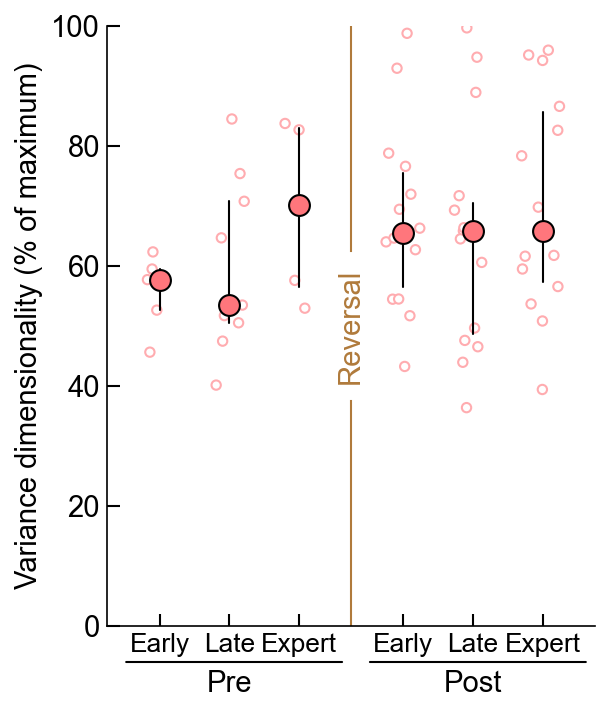

In [33]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [dim_var_preearly,dim_var_prelate,dim_var_preexpert,dim_var_postearly,dim_var_postlate,dim_var_postexpert]
# data = [dim_covar_preearly,dim_covar_prelate,dim_covar_preexpert,dim_covar_postearly,dim_covar_postlate,dim_covar_postexpert]
# data = [dim_GT_preearly,dim_GT_prelate,dim_GT_preexpert,dim_GT_postearly,dim_GT_postlate,dim_GT_postexpert]
data_max = [dim_max_preearly,dim_max_prelate,dim_max_preexpert,dim_max_postearly,dim_max_postlate,dim_max_postexpert]
data = [d / d_m for d,d_m in zip(data,data_max)]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,20,40,60,80,100])
ylab = ax.set_ylabel('Variance dimensionality (% of maximum)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','dimensionality_var over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [39]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_var_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_var_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_var_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_var_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_var_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_var_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.048129   4.0  0.012032  0.542387  0.705098  0.029651
1          context  0.193278   1.0  0.193278  8.712448  0.004280  0.109298
2  phase * context  0.023338   4.0  0.005834  0.263003  0.900740  0.014601
3         Residual  1.575070  71.0  0.022184       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.070003  0.324647 -0.849376
12  post-expert  baseline  experimental  0.129859  0.324647 -0.866497
13    post-late  baseline  experimental  0.230005  0.383342 -0.526411
14   pre-expert  baseline  experimental  0.412698  0.515873 -1.035970
15     pre-late  baseline  experimental  0.797203  0.797203 -0.319264


In [44]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_var_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_var_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_var_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_var_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_var_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_var_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.096707   3.0  0.032236  1.145143  0.336307  0.042710
1          context  0.016676   1.0  0.016676  0.592386  0.443853  0.007635
2  phase * context  0.043687   3.0  0.014562  0.517310  0.671602  0.019757
3         Residual  2.167545  77.0  0.028150       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.498739  0.780505 -0.296262
8     post-late  baseline  experimental  0.585379  0.780505  0.174338
9    pre-expert  baseline  experimental  0.330070  0.780505 -0.577362
10     pre-late  baseline  experimental  0.797203  0.797203 -0.319264


In [34]:
data_dec1 = SimpleNamespace()
data_dec2 = SimpleNamespace()
data_dec1.preearly = ilep.rmnan(np.abs(dim_var_preearly / dim_max_preearly))
data_dec1.prelate = ilep.rmnan(np.abs(dim_var_prelate / dim_max_prelate))
data_dec1.preexpert = ilep.rmnan(np.abs(dim_var_preexpert / dim_max_preexpert))
data_dec1.postearly = []
data_dec1.postlate = []
data_dec1.postexpert = []
data_dec2.preearly = ilep.rmnan(np.abs(dim_var_postearly / dim_max_postearly))
data_dec2.prelate = ilep.rmnan(np.abs(dim_var_postlate / dim_max_postlate))
data_dec2.preexpert = ilep.rmnan(np.abs(dim_var_postexpert / dim_max_postexpert))
data_dec2.postearly = []
data_dec2.postlate = []
data_dec2.postexpert = []
ilep.nonparametricIndependentStatsCompareToOther(data_dec1,data_dec2)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.043870   2.0  0.021935  0.801177  0.453968  0.028309
1          context  0.047401   1.0  0.047401  1.731348  0.193697  0.030518
2  phase * context  0.022436   2.0  0.011218  0.409731  0.665838  0.014681
3         Residual  1.505810  55.0  0.027378       NaN       NaN       NaN

        phase  A  B     p-unc    p-corr    hedges
4   pre-early  A  B  0.070003  0.210010 -0.849376
5  pre-expert  A  B  0.878431  0.878431 -0.062848
6    pre-late  A  B  0.720515  0.878431 -0.274304


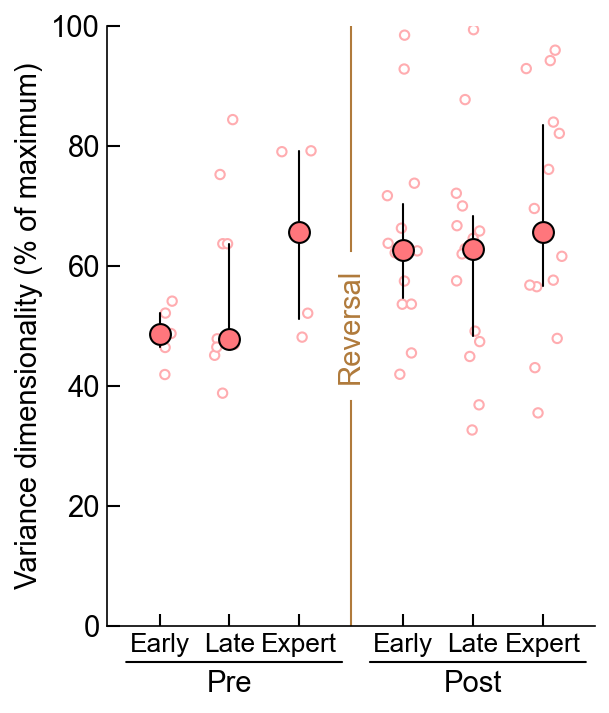

In [35]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
# data = [dim_var_preearly,dim_var_prelate,dim_var_preexpert,dim_var_postearly,dim_var_postlate,dim_var_postexpert]
data = [dim_covar_preearly,dim_covar_prelate,dim_covar_preexpert,dim_covar_postearly,dim_covar_postlate,dim_covar_postexpert]
# data = [dim_GT_preearly,dim_GT_prelate,dim_GT_preexpert,dim_GT_postearly,dim_GT_postlate,dim_GT_postexpert]
data_max = [dim_max_preearly,dim_max_prelate,dim_max_preexpert,dim_max_postearly,dim_max_postlate,dim_max_postexpert]
data = [d / d_m for d,d_m in zip(data,data_max)]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,20,40,60,80,100])
ylab = ax.set_ylabel('Variance dimensionality (% of maximum)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','dimensionality_covar over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [40]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_covar_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_covar_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_covar_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_covar_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_covar_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_covar_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source        SS    DF        MS          F     p-unc       np2
0            phase  0.054604   4.0  0.013651   0.603468  0.661389  0.032880
1          context  0.349101   1.0  0.349101  15.432654  0.000196  0.178551
2  phase * context  0.024352   4.0  0.006088   0.269132  0.896901  0.014936
3         Residual  1.606085  71.0  0.022621        NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.019436  0.084709 -1.093761
12  post-expert  baseline  experimental  0.033884  0.084709 -1.064345
13    post-late  baseline  experimental  0.118550  0.197583 -0.762792
14   pre-expert  baseline  experimental  0.285714  0.357143 -1.223426
15     pre-late  baseline  experimental  0.606394  0.606394 -0.593024


In [43]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_covar_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_covar_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_covar_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_covar_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_covar_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_covar_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.127592   3.0  0.042531  1.483355  0.225686  0.054635
1          context  0.025560   1.0  0.025560  0.891459  0.348036  0.011445
2  phase * context  0.055030   3.0  0.018343  0.639769  0.591720  0.024320
3         Residual  2.207734  77.0  0.028672       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.498739  0.776653 -0.352611
8     post-late  baseline  experimental  0.776653  0.776653  0.197963
9    pre-expert  baseline  experimental  0.260140  0.776653 -0.450430
10     pre-late  baseline  experimental  0.606394  0.776653 -0.593024


In [36]:
data_dec1 = SimpleNamespace()
data_dec2 = SimpleNamespace()
data_dec1.preearly = ilep.rmnan(np.abs(dim_covar_preearly / dim_max_preearly))
data_dec1.prelate = ilep.rmnan(np.abs(dim_covar_prelate / dim_max_prelate))
data_dec1.preexpert = ilep.rmnan(np.abs(dim_covar_preexpert / dim_max_preexpert))
data_dec1.postearly = []
data_dec1.postlate = []
data_dec1.postexpert = []
data_dec2.preearly = ilep.rmnan(np.abs(dim_covar_postearly / dim_max_postearly))
data_dec2.prelate = ilep.rmnan(np.abs(dim_covar_postlate / dim_max_postlate))
data_dec2.preexpert = ilep.rmnan(np.abs(dim_covar_postexpert / dim_max_postexpert))
data_dec2.postearly = []
data_dec2.postlate = []
data_dec2.postexpert = []
ilep.nonparametricIndependentStatsCompareToOther(data_dec1,data_dec2)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.053385   2.0  0.026692  0.935703  0.398465  0.032906
1          context  0.072599   1.0  0.072599  2.544950  0.116378  0.044225
2  phase * context  0.037509   2.0  0.018755  0.657443  0.522199  0.023349
3         Residual  1.568966  55.0  0.028527       NaN       NaN       NaN

        phase  A  B     p-unc    p-corr    hedges
4   pre-early  A  B  0.019436  0.058308 -1.093761
5  pre-expert  A  B  0.720915  0.720915 -0.173478
6    pre-late  A  B  0.550985  0.720915 -0.249377


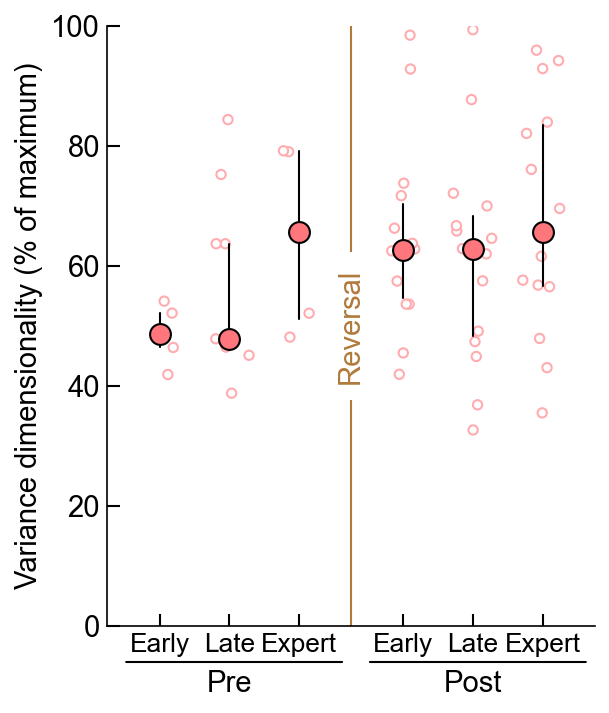

In [37]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
# data = [dim_var_preearly,dim_var_prelate,dim_var_preexpert,dim_var_postearly,dim_var_postlate,dim_var_postexpert]
# data = [dim_covar_preearly,dim_covar_prelate,dim_covar_preexpert,dim_covar_postearly,dim_covar_postlate,dim_covar_postexpert]
data = [dim_GT_preearly,dim_GT_prelate,dim_GT_preexpert,dim_GT_postearly,dim_GT_postlate,dim_GT_postexpert]
data_max = [dim_max_preearly,dim_max_prelate,dim_max_preexpert,dim_max_postearly,dim_max_postlate,dim_max_postexpert]
data = [d / d_m for d,d_m in zip(data,data_max)]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,20,40,60,80,100])
ylab = ax.set_ylabel('Variance dimensionality (% of maximum)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','dimensionality_GT over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [41]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_GT_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_GT_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_GT_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_GT_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_GT_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_GT_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source        SS    DF        MS          F     p-unc       np2
0            phase  0.054604   4.0  0.013651   0.603468  0.661389  0.032880
1          context  0.349101   1.0  0.349101  15.432654  0.000196  0.178551
2  phase * context  0.024352   4.0  0.006088   0.269132  0.896901  0.014936
3         Residual  1.606085  71.0  0.022621        NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.019436  0.084709 -1.093761
12  post-expert  baseline  experimental  0.033884  0.084709 -1.064345
13    post-late  baseline  experimental  0.118550  0.197583 -0.762792
14   pre-expert  baseline  experimental  0.285714  0.357143 -1.223426
15     pre-late  baseline  experimental  0.606394  0.606394 -0.593024


In [42]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_GT_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_GT_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_GT_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_GT_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_GT_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_GT_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.127592   3.0  0.042531  1.483355  0.225686  0.054635
1          context  0.025560   1.0  0.025560  0.891459  0.348036  0.011445
2  phase * context  0.055030   3.0  0.018343  0.639769  0.591720  0.024320
3         Residual  2.207734  77.0  0.028672       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.498739  0.776653 -0.352611
8     post-late  baseline  experimental  0.776653  0.776653  0.197963
9    pre-expert  baseline  experimental  0.260140  0.776653 -0.450430
10     pre-late  baseline  experimental  0.606394  0.776653 -0.593024


In [38]:
data_dec1 = SimpleNamespace()
data_dec2 = SimpleNamespace()
data_dec1.preearly = ilep.rmnan(np.abs(dim_GT_preearly / dim_max_preearly))
data_dec1.prelate = ilep.rmnan(np.abs(dim_GT_prelate / dim_max_prelate))
data_dec1.preexpert = ilep.rmnan(np.abs(dim_GT_preexpert / dim_max_preexpert))
data_dec1.postearly = []
data_dec1.postlate = []
data_dec1.postexpert = []
data_dec2.preearly = ilep.rmnan(np.abs(dim_GT_postearly / dim_max_postearly))
data_dec2.prelate = ilep.rmnan(np.abs(dim_GT_postlate / dim_max_postlate))
data_dec2.preexpert = ilep.rmnan(np.abs(dim_GT_postexpert / dim_max_postexpert))
data_dec2.postearly = []
data_dec2.postlate = []
data_dec2.postexpert = []
ilep.nonparametricIndependentStatsCompareToOther(data_dec1,data_dec2)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.053385   2.0  0.026692  0.935703  0.398465  0.032906
1          context  0.072599   1.0  0.072599  2.544950  0.116378  0.044225
2  phase * context  0.037509   2.0  0.018755  0.657443  0.522199  0.023349
3         Residual  1.568966  55.0  0.028527       NaN       NaN       NaN

        phase  A  B     p-unc    p-corr    hedges
4   pre-early  A  B  0.019436  0.058308 -1.093761
5  pre-expert  A  B  0.720915  0.720915 -0.173478
6    pre-late  A  B  0.550985  0.720915 -0.249377


In [7]:
sessionfile = ilep.getRandomSession(act_directory)
print(len(sessionfile.clusters.good))
print(sessionfile.meta)

22
namespace(animal='AE_240', arraystart=0, date='04/28/2023', day_of_recording=8, day_of_reversal=9, day_of_training=29, depth=828, directory='D:\\DualRecording\\AE_240\\AE_240 8\\AC\\', files=['April 28 2023 AC Second Reversal AE_240_8001', 'April 28 2023 AC Second Reversal AE_240_8002', 'April 28 2023 AC Second Reversal AE_240_8003'], fs=30000, length_in_minutes=40.64517222222222, length_in_samples=73161310.0, length_in_seconds=2438.7103333333334, length_in_trials=600, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=11417, region='AC', task='second reversal', tonelength=0.1, triallength=2.5)


In [ ]:
np.array

In [27]:

def ReservoirSample(S,k):# R[1..k]):
    n = len(S)
    R = np.array()
    
    #fill the reservoir array
    for i in range(k):
        R[i] = S[i]

    #(* random() generates a uniform (0,1) random number *)
    W = np.exp(np.log(np.random.random())/k)

    while i <= n:
        i = i + np.floor(np.log(np.random.random())/np.log(1-W)) + 1
        if i <= n
            #(* replace a random item of the reservoir with item i *)
            R[randomInteger(1,k)] = S[i]  // random index between 1 and k, inclusive
            W = W * np.exp(np.log(np.random.random())/k)

SyntaxError: invalid syntax (<ipython-input-27-4d2c7b0103c0>, line 12)

In [44]:
def findBestEnsemble(sessionfile,size=10,max_iterations_to_test = 3003):
    clusts = sessionfile.clusters.good
    if len(clusts) < size:
        print(f"{ilep.generateDateString(sessionfile)} has too few cells to find a size {size} ensemble")
        return []
    
    if comb(len(clusts),size) <= max_iterations_to_test:
        ### Test all combinations to find absolute best ensemble
        ensembles_to_test = combinations(clusts,size)
    else:
        ### Sample randomly from reservoir of all cells
        ensembles_to_test = np.array(combinations(clusts,size))
        print(ensembles_to_test.shape)
        ensembles_to_test = np.random.permutation(ensembles_to_test)
        ensembles_to_test = ensembles_to_test(range(max_iterations_to_test))

    best_ensemble = []
    largest_intersection = -np.Inf
    for ensemble in tqdm(ensembles_to_test):
        intersection = ilep.getAllConditions(sessionfile,ensemble)['all_trials'].trials
        if len(intersection) > largest_intersection:
            best_ensemble = ensemble
            largest_intersection = len(intersection)
            
    return best_ensemble

In [45]:
findBestEnsemble(sessionfile)

()


IndexError: x must be an integer or at least 1-dimensional

In [ ]:
25 it/s

In [23]:
comb(16,10) / 25 / 60

5.338666666666667

In [50]:
a = [1,2,3,4,5,6,7,8,9,10]
b = combinations(a,3)

In [51]:
list(b)

[(1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (1, 2, 8),
 (1, 2, 9),
 (1, 2, 10),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 3, 7),
 (1, 3, 8),
 (1, 3, 9),
 (1, 3, 10),
 (1, 4, 5),
 (1, 4, 6),
 (1, 4, 7),
 (1, 4, 8),
 (1, 4, 9),
 (1, 4, 10),
 (1, 5, 6),
 (1, 5, 7),
 (1, 5, 8),
 (1, 5, 9),
 (1, 5, 10),
 (1, 6, 7),
 (1, 6, 8),
 (1, 6, 9),
 (1, 6, 10),
 (1, 7, 8),
 (1, 7, 9),
 (1, 7, 10),
 (1, 8, 9),
 (1, 8, 10),
 (1, 9, 10),
 (2, 3, 4),
 (2, 3, 5),
 (2, 3, 6),
 (2, 3, 7),
 (2, 3, 8),
 (2, 3, 9),
 (2, 3, 10),
 (2, 4, 5),
 (2, 4, 6),
 (2, 4, 7),
 (2, 4, 8),
 (2, 4, 9),
 (2, 4, 10),
 (2, 5, 6),
 (2, 5, 7),
 (2, 5, 8),
 (2, 5, 9),
 (2, 5, 10),
 (2, 6, 7),
 (2, 6, 8),
 (2, 6, 9),
 (2, 6, 10),
 (2, 7, 8),
 (2, 7, 9),
 (2, 7, 10),
 (2, 8, 9),
 (2, 8, 10),
 (2, 9, 10),
 (3, 4, 5),
 (3, 4, 6),
 (3, 4, 7),
 (3, 4, 8),
 (3, 4, 9),
 (3, 4, 10),
 (3, 5, 6),
 (3, 5, 7),
 (3, 5, 8),
 (3, 5, 9),
 (3, 5, 10),
 (3, 6, 7),
 (3, 6, 8),
 (3, 6, 9),
 (3, 6, 10),
 (3, 7, 8),
 (3, 7, 9),
 (3, 7, 10

In [30]:
data_dec = SimpleNamespace()
data_dec.preearly = ilep.rmnan(np.abs(dim_var_preearly / dim_max_preearly))
data_dec.prelate = ilep.rmnan(np.abs(dim_var_prelate / dim_max_prelate))
data_dec.preexpert = ilep.rmnan(np.abs(dim_var_preexpert / dim_max_preexpert))
data_dec.postearly = ilep.rmnan(np.abs(dim_var_postearly / dim_max_postearly))
data_dec.postlate = ilep.rmnan(np.abs(dim_var_postlate / dim_max_postlate))
data_dec.postexpert = ilep.rmnan(np.abs(dim_var_postexpert / dim_max_postexpert))
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.048129   4.0  0.012032  0.542387  0.705098  0.029651
1          context  0.193278   1.0  0.193278  8.712448  0.004280  0.109298
2  phase * context  0.023338   4.0  0.005834  0.263003  0.900740  0.014601
3         Residual  1.575070  71.0  0.022184       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.070003  0.324647 -0.849376
12  post-expert  baseline  experimental  0.129859  0.324647 -0.866497
13    post-late  baseline  experimental  0.230005  0.383342 -0.526411
14   pre-expert  baseline  experimental  0.412698  0.515873 -1.035970
15     pre-late  baseline  experimental  0.797203  0.797203 -0.319264


In [105]:
sessionfile = ilep.getRandomSession(act_directory)
print(len(sessionfile.clusters.good))
print(sessionfile.meta)

26
namespace(animal='BS_173', arraystart=0, behavior='naive', condition='postreversal naive', date='9/20/2022', day_of_recording=9, day_of_reversal=5, day_of_training=20, depth=830, directory='D:\\DualRecording\\BS_173\\BS_173 9\\AC\\', files=['September 20 2022 AC BS_173_9001', 'September 20 2022 AC BS_173_9002', 'September 20 2022 AC BS_173_9003'], first_tuning_trial=320, first_tuning_trial_corrected=322, fs=30000, length_in_minutes=35.21225944444445, length_in_samples=63382067.0, length_in_seconds=2112.7355666666667, length_in_trials=322, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=9716, region='AC', task='tuning reversal', tonelength=0.1, triallength=2.5)


In [133]:
def findEnsembles(sessionfile,ensemble_size = 10,search_iterations = 1000, min_intersection_trials = 100):
    
    n = len(sessionfile.clusters.good)
    n_ensembles = int(np.floor(n / ensemble_size))
    
    if n_ensembles == 0:
        return []
    
    best_ensembles = []
    current_n_ensembles = 0
    current_min_intersection = 0
    current_ensemble_intersection = 0
    for iteration in range(search_iterations):
        permuted_cells = np.random.permutation(sessionfile.clusters.good)
        
        ensembles = [[]]*n_ensembles
        for idx in range(n_ensembles):
            ensembles[idx] = permuted_cells[ range(idx*ensemble_size,idx*ensemble_size+ensemble_size) ]
        ensembles = np.array(ensembles)
        
        intersections = np.array([len(ilep.getAllConditions(sessionfile,ensembles[idx])['all_trials'].trials) for idx in range(n_ensembles)])
        
        valid_ensembles_mask = np.greater_equal(intersections,min_intersection_trials)
        valid_ensembles = ensembles[valid_ensembles_mask]
        n_valid_ensembles = np.sum(valid_ensembles_mask)
        min_intersection = np.min(intersections[valid_ensembles_mask])
        mean_intersection = np.mean(intersections[valid_ensembles_mask])
        
        if n_valid_ensembles > current_n_ensembles:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
        elif n_valid_ensembles == current_n_ensembles and min_intersection > current_min_intersection:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
        elif n_valid_ensembles == current_n_ensembles and min_intersection == current_min_intersection and mean_intersection > current_ensemble_intersection:
            best_ensembles = valid_ensembles
            current_n_ensembles = n_valid_ensembles
            current_n_intersection = min_intersection
            current_ensemble_intersection = mean_intersection
            
    if current_n_ensembles == 0:
        return []
    
#     print('TOTAL')
#     print(ensembles)
#     print(valid_ensembles)
#     print(f"n:  {n_valid_ensembles}")
#     print(f"min : {min_intersection}")
#     print(f"mean: {mean_intersection}")
#     print()
    
    return best_ensembles

In [152]:
starttime = pytime.time()
findEnsembles(sessionfile,search_iterations = 100)
endtime = pytime.time()
time = endtime - starttime
print(f"{time} seconds elapsed")

TOTAL
[[231  47 159 225 157 144 200 170 145 115]
 [ 68  27 151 158 219 187 226 218  37 233]]
[[231  47 159 225 157 144 200 170 145 115]
 [ 68  27 151 158 219 187 226 218  37 233]]
n:  2
min : 226
mean: 226.5

19.835256576538086 seconds elapsed


In [158]:
seconds = 145 * time
print(seconds)

2876.1122035980225


In [159]:
minutes = seconds / 60
print(minutes)

47.93520339330038


In [160]:
print(minutes/10)

4.793520339330038


In [26]:
EILphases

array(['pre expert', 'pre expert', 'switch', 'post early', 'post early',
       'pre late', 'pre late', 'pre expert', 'nan', 'switch',
       'post early', 'post early', 'post early', 'post late',
       'post expert', 'post expert', 'pre late', 'pre late', 'pre late',
       'pre late', 'pre late', 'pre late', 'pre late', 'post expert',
       'post expert', 'switch', 'post early', 'post early', 'post early',
       'post early', 'post early', 'post late', 'post late', 'post late',
       'post expert', 'post expert', 'switch', 'post early', 'post early',
       'post early', 'post early', 'post late', 'post late',
       'post expert', 'post expert', 'pre late', 'pre expert', 'switch',
       'post late', 'post late', 'post expert', 'pre early', 'pre early',
       'pre early', 'pre early', 'pre late', 'pre late', 'pre late',
       'switch', 'nan', 'pre early', 'pre early', 'pre late', 'pre late',
       'pre late', 'post expert', 'nan', 'post expert', 'post expert',
       'post ex

In [27]:
for idx,session in enumerate(EnumSession):
#     sessionfile = ilep.loadSessionCached(act_directory,session)
    phase = EILphases[idx]
    
    if phase == 'pre expert':
        
        print(session)

BS_108_1_AC.pickle
BS_108_2_AC.pickle
BS_40_12_AC.pickle
BS_49_12_AC.pickle
BS_70_3_AC.pickle
BS_72_1_AC.pickle
BS_72_2_AC.pickle
BS_87_1_AC.pickle
BS_87_2_AC.pickle
DS_15_1_AC.pickle
DS_19_1_AC.pickle


# CR/NCR Ensemble Dimensionality metrics

In [87]:
EnumSession = []
# EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    EnumSession.append(session)
    
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)

100%|██████████| 728/728 [00:10<00:00, 67.42it/s] 


In [88]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 145/145 [00:01<00:00, 118.88it/s]

errors for: []


In [89]:
dim25msfilename = 'D:\\dimenstionality_25ms.csv'
dim50msfilename = 'D:\\dimenstionality_50ms.csv'
dim100msfilename = 'D:\\dimenstionality_100ms.csv'
dimsize5filename = 'D:\\dimenstionality_size5.csv'
dimsize10filename = 'D:\\dimenstionality_size10.csv'
dimsize15filename = 'D:\\dimenstionality_size15.csv'

In [90]:
dim_25ms_df = pd.read_csv(dim25msfilename)
dim_50ms_df = pd.read_csv(dim50msfilename)
dim_100ms_df = pd.read_csv(dim100msfilename)
dim_size5_df = pd.read_csv(dimsize5filename)
dim_size10_df = pd.read_csv(dimsize10filename)
dim_size15_df = pd.read_csv(dimsize15filename)
dim_df = pd.concat([dim_25ms_df,dim_50ms_df,dim_100ms_df,dim_size5_df,dim_size10_df,dim_size15_df])

# passive_df = pd.read_csv(passivedecodingfilename)
# choice_df = pd.read_csv(choicedecodingfilename)
# dec_df = pd.concat([stim_25s_df,choice_df,passive_df])

def getDataPoints(df,session,binlength,size,column):
    df = df[df['session']==session]
    df = df[df['bin_length']==binlength]
    df = df[df['size']==size]
    val = list(df[column])
    
    return val
#     if len(val) == 1:
#         return val[0]
#     elif len(val) <= 0:
#         return np.nan
#     else:
#         return val

<ipython-input-117-935363c72acd>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-117-935363c72acd>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.array(data_NCR_ratio)


bin length 50, size 5, metric d_GT
            Source           SS      DF         MS          F         p-unc  \
0            phase    11.505035     3.0   3.835012   6.302607  2.912671e-04   
1          context     3.118643     1.0   3.118643   5.125299  2.363110e-02   
2  phase * context    58.228944     3.0  19.409648  31.898569  2.232100e-20   
3         Residual  2516.065695  4135.0   0.608480        NaN           NaN   

        np2  
0  0.004552  
1  0.001238  
2  0.022619  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.170594e-05  2.341188e-05 -0.270368
8     post-late  baseline  experimental  5.762830e-04  7.683773e-04  0.156589
9    pre-expert  baseline  experimental  8.773585e-02  8.773585e-02 -0.225716
10     pre-late  baseline  experimental  1.160922e-13  4.643690e-13  0.715810
key preearly has 212 non-nan elements
key prelate has 322 non-nan elements
key preexpert has 62 non-nan elem

<ipython-input-117-935363c72acd>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-117-935363c72acd>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.array(data_NCR_ratio)


bin length 50, size 5, metric d_GT
            Source           SS      DF        MS          F         p-unc  \
0            phase     7.521559     3.0  2.507186   4.362653  4.514879e-03   
1          context     0.958516     1.0  0.958516   1.667874  1.966606e-01   
2  phase * context    24.949294     3.0  8.316431  14.471084  2.394384e-09   
3         Residual  1464.892560  2549.0  0.574693        NaN           NaN   

        np2  
0  0.005108  
1  0.000654  
2  0.016746  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000080  0.000159 -0.343223
8     post-late  baseline  experimental  0.000034  0.000134  0.260085
9    pre-expert  baseline  experimental  0.038765  0.051687  0.346380
10     pre-late  baseline  experimental  0.445072  0.445072  0.078804
key preearly has 145 non-nan elements
key prelate has 238 non-nan elements
key preexpert has 63 non-nan elements
key postearly has 764 non-nan elements
k

<ipython-input-117-935363c72acd>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
<ipython-input-117-935363c72acd>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_NCR_ratio = np.array(data_NCR_ratio)


bin length 50, size 5, metric d_GT
            Source          SS      DF         MS          F         p-unc  \
0            phase    5.276566     3.0   1.758855   3.283785  2.018711e-02   
1          context    1.217684     1.0   1.217684   2.273418  1.318592e-01   
2  phase * context   31.019069     3.0  10.339690  19.304215  3.056098e-12   
3         Residual  677.021450  1264.0   0.535618        NaN           NaN   

        np2  
0  0.007734  
1  0.001795  
2  0.043810  
3       NaN  

          phase         A             B         p-unc    p-corr    hedges
7   post-expert  baseline  experimental  2.254560e-06  0.000005 -0.804290
8     post-late  baseline  experimental  1.394779e-04  0.000186  0.317243
9    pre-expert  baseline  experimental  7.300826e-07  0.000003 -0.795453
10     pre-late  baseline  experimental  5.586100e-01  0.558610 -0.013201
key preearly has 176 non-nan elements
key prelate has 113 non-nan elements
key preexpert has 66 non-nan elements
key postearly has 45

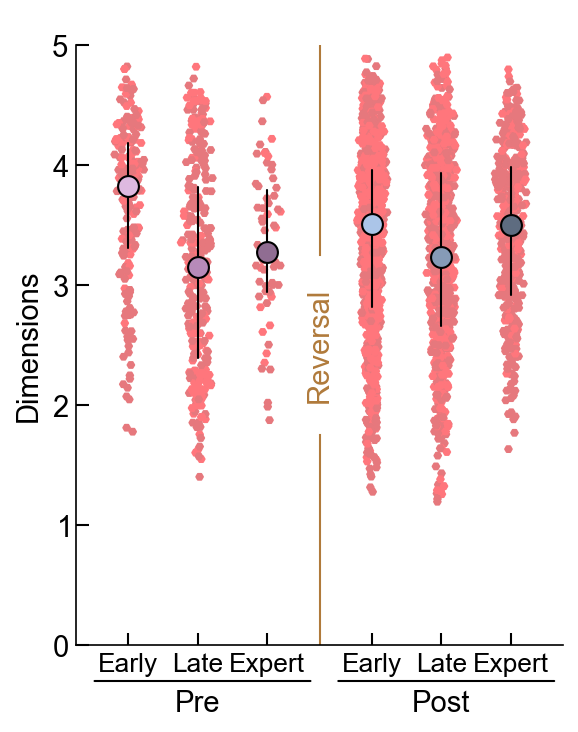

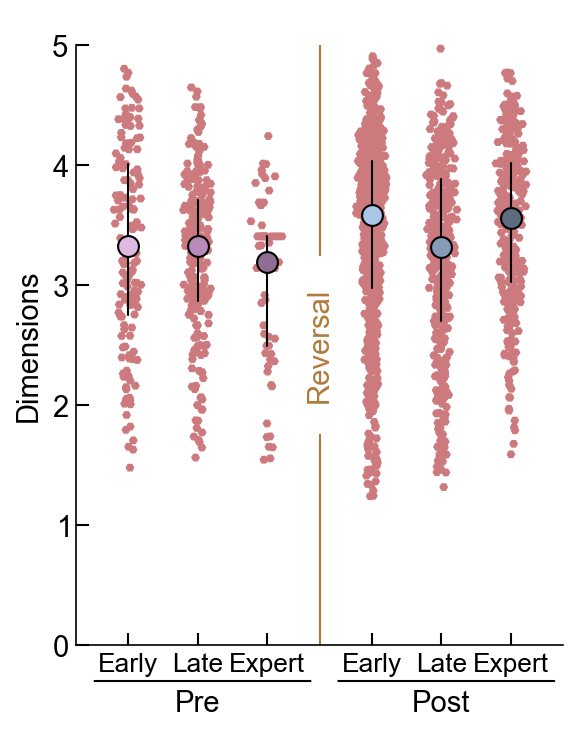

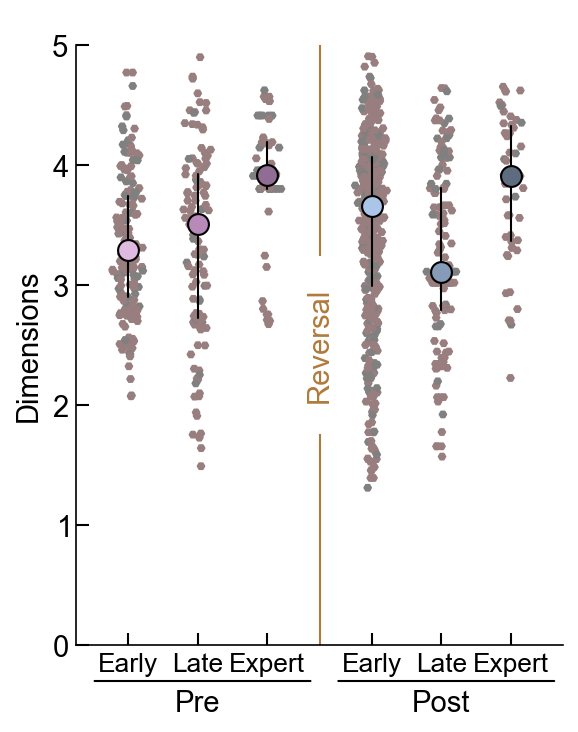

In [117]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def plotFigureCRNCR(CR_NCR,metric,bin_length=50,size_of_ensembles=10):
    fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
    switch_offset = 0.25

    ################################################################################################################

    size = 10
    summary_size=100
    summary_width=1#0.75

    mn = 3.5
    spread = 2.5

    ###

    FRmod_baseline_median = 3.5
    phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    data = [0,0,0,0,0,0]
    data_NCR_ratio = [0,0,0,0,0,0]
    for idx,phase in enumerate(phases):
        phase_idx = np.char.equal(EILphases,phase)
        sessions_in_phase = np.array(EnumSession)[phase_idx]

        temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,metric) for session in sessions_in_phase]
        temp = [t for t in temp if len(t)>0]
        temp = np.concatenate(temp)
        data[idx] = temp

        temp = [getDataPoints(dim_df,session,bin_length,size_of_ensembles,'NCR_ratio') for session in sessions_in_phase]
        temp = [t for t in temp if len(t)>0]
        temp = np.concatenate(temp)
        data_NCR_ratio[idx] = temp

    data = np.array(data)
    data_NCR_ratio = np.array(data_NCR_ratio)
    labels = ['Early','Late','Expert','Early','Late','Expert']
    numCon = len(data)
    
    ### Handle CR/NCR
    if CR_NCR == 'CR':
        ensemble_mask = [np.less_equal(data_NCR,0.3) for data_NCR in data_NCR_ratio]
        data = [d[m] for d,m in zip(data,ensemble_mask)]
        data_NCR_ratio = [d[m] for d,m in zip(data_NCR_ratio,ensemble_mask)]
    if CR_NCR == 'NCR':
        ensemble_mask = [np.greater_equal(data_NCR,0.8) for data_NCR in data_NCR_ratio]
        data = [d[m] for d,m in zip(data,ensemble_mask)]
        data_NCR_ratio = [d[m] for d,m in zip(data_NCR_ratio,ensemble_mask)]
    if CR_NCR == 'Mixed':
        ensemble_mask = [np.logical_and(np.greater_equal(data_NCR,0.5),np.less_equal(data_NCR,0.7)) for data_NCR in data_NCR_ratio]
        data = [d[m] for d,m in zip(data,ensemble_mask)]
        data_NCR_ratio = [d[m] for d,m in zip(data_NCR_ratio,ensemble_mask)]

    ###
    X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
    _,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5,minjitter=0.075)
    X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5,minjitter=0.075)
    colors = NCR_CR_cmap( (1-np.concatenate(data_NCR_ratio)) )

    ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=1,zorder=-10,marker='H',clip_on=False)

    #Plot summary
    for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
        column = ilep.rmnan(column)
        percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100

        eye_color = PHASE_COLORS[idx]
        border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    #     r,g,b = mpl.colors.to_rgb(eye_color)
    #     h,l,s = colorsys.rgb_to_hls(r,g,b)

        Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    #     median = np.mean(column)
    #     Q1 = median - sem(column)
    #     Q1 = median + sem(column)

        ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


    ################################################################################################################
    labels = ['Early','Late','Expert','Early','Late','Expert']

    if metric == 'd_covar':
        ax.set_ylim([0.6*size_of_ensembles,size_of_ensembles])
        ax.set_yticks(np.array([3,4,5])*size_of_ensembles/5)
    else:
        ax.set_ylim([0,size_of_ensembles])
        ax.set_yticks(np.array([0,1,2,3,4,5])*size_of_ensembles/5)
    # ax.set_yticks([0,1,2,3,4,5])
    ylab = ax.set_ylabel('Dimensions')

    ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
    ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
    ax.set_xticklabels(labels)
    # xlab = ax.set_xlabel('Example X label')

    xtick_pos_pre = ax.get_xticks()[1]
    xtick_pos_post = ax.get_xticks()[4]
    Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
    t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
    t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
    ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    ax.tick_params(direction='in', length=6, width=1)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass

    Y = np.mean(ax.get_ylim())
    t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
    ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.3],lw=1,color=SWITCH_COLOR)
    ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.3],lw=1,color=SWITCH_COLOR)

    # ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

    ttl = ax.set_title(' ')
    artists = [ylab,t1,t2,ttl]
    fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC dimensionality '+CR_NCR+' ensembles '+str(bin_length)+'ms size '+str(size_of_ensembles)+' '+metric+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    
    data_dec = SimpleNamespace()
    data_dec.preearly = np.abs(data[0])
    data_dec.prelate = np.abs(data[1])
    data_dec.preexpert = np.abs(data[2])
    data_dec.postearly = np.abs(data[3])
    data_dec.postlate = np.abs(data[4])
    data_dec.postexpert = np.abs(data[5])
    print(f"bin length {bin_length}, size {size_of_ensembles}, metric {metric}")
    ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
                         
plotFigureCRNCR('NCR','d_GT',size_of_ensembles=5)
plotFigureCRNCR('Mixed','d_GT',size_of_ensembles=5)
plotFigureCRNCR('CR','d_GT',size_of_ensembles=5)

In [114]:
dim_df

,Unnamed: 0,bin_length,size,session,clust,d_var,d_covar,d_GT,FRmods,NCR_ratio
0,0,25.0,10,AE_238_10_AC.pickle,"[7, 35, 52, 55, 58, 64, 66, 70, 82, 115]",5.340836,9.924736,5.300639,"[4.05466970387243, 4.510250569476077, 0.561883...",0.500000
1,1,25.0,10,AE_238_10_AC.pickle,"[7, 26, 35, 48, 58, 70, 82, 99, 108, 123]",6.614492,9.952651,6.583173,"[4.05466970387243, 2.703113135914959, 4.510250...",0.600000
2,2,25.0,10,AE_238_10_AC.pickle,"[7, 17, 26, 49, 52, 58, 64, 90, 120, 123]",5.238497,9.993491,5.235087,"[4.05466970387243, 1.67046317388003, 2.7031131...",0.800000
3,3,25.0,10,AE_238_10_AC.pickle,"[7, 18, 26, 48, 49, 55, 64, 108, 120, 123]",7.250796,9.961837,7.223125,"[4.05466970387243, 2.460136674259679, 2.703113...",0.600000
4,4,25.0,10,AE_238_10_AC.pickle,"[35, 38, 48, 49, 52, 58, 64, 66, 108, 123]",4.630596,9.981169,4.621876,"[4.510250569476077, 5.31645569620253, 2.171602...",0.700000
...,...,...,...,...,...,...,...,...,...,...
15686,15686,50.0,15,DS_28_6_AC.pickle,"[0, 2, 6, 7, 26, 27, 28, 30, 36, 51, 52, 63, 7...",9.751871,14.577101,9.476934,"[1.5527065527065513, 0.7549857549857549, 2.108...",0.933333
15687,15687,50.0,15,DS_28_6_AC.pickle,"[0, 2, 7, 26, 27, 28, 30, 34, 36, 49, 50, 51, ...",9.357392,12.580494,7.848041,"[1.5527065527065513, 0.7549857549857549, 3.073...",0.933333
15688,15688,50.0,15,DS_28_6_AC.pickle,"[0, 2, 6, 7, 26, 27, 49, 50, 51, 52, 57, 63, 6...",8.488781,12.697676,7.185853,"[1.5527065527065513, 0.7549857549857549, 2.108...",0.933333
15689,15689,50.0,15,DS_28_6_AC.pickle,"[2, 6, 7, 26, 27, 28, 30, 34, 49, 50, 51, 52, ...",9.386400,13.371977,8.367649,"[0.7549857549857549, 2.108262108262111, 3.0738...",1.000000


In [113]:
len(np.unique(list(dim_df['clust'])))

124888

In [120]:
a = [1,5,3,6,8,4,553,6,7,5,3]
b = [2,7,4,3,5,76,8,9,3,2,3,4,6,7,87]
c = [67,5,4,3,3,5,78,9,0,0,98,6,4,3,23,4,678]

A = [str(a),str(b)]

In [121]:
A

['[1, 5, 3, 6, 8, 4, 553, 6, 7, 5, 3]',
 '[2, 7, 4, 3, 5, 76, 8, 9, 3, 2, 3, 4, 6, 7, 87]']

In [124]:
str(c) in A

False